<a href="https://colab.research.google.com/github/mqc25/Cell_count/blob/master/CellDensityCategory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
Determine Centroid Location

'''


### Imports
%matplotlib inline

import os
import sys
import random
import math
import string
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import imageio

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle


In [0]:
def get_mini_image(fname):

    newdata = 0 #dummy placeholder for valid and error data

    print('Getting mini image from ', fname)

    im = imageio.imread(fname)

    image_size = np.shape(im)
    print('subset image size is ',image_size[0],image_size[1])

    #There are some images that don't follow the normal screen capture format
    # They must be handled outside of this function. Mark them for later use?
    if (image_size[1] < 600):
        print('Count image size is too small. Skipping. Cols = ',image_size[1])
        return newdata

    #
    #Get column line to find the proper y point to start at
    # -use 86% of x to find column to plot
    pcol = int(image_size[1] * 0.86)
    test_col = np.asarray(im[:,pcol,0])

#    plt.figure()
#    plt.plot(im[:,pcol,:])
#    plt.title('Alignment column')

    #skip the highest 10% of the plot, since that is likely image noise.
    mval = np.median(test_col)
    print('median value is ', mval)
    noise_area = image_size[0] * 0.1
    total_row_length = int(image_size[0] - noise_area)
    even_line = np.median(test_col[total_row_length-50:total_row_length])
    spikes = np.argwhere(test_col[0:total_row_length] >= 245)
    if (np.size(spikes)==0):
        #failure in spike detection, likely due to image with eye photo instead
        #of normal format
        print('Spike Failure! Check Image format')
        return newdata
    print('start row point should be ', spikes[-1])



    #the count images seem to all share the same sizes. This default should work
    start_row = spikes[-1][0]
    start_col = int(image_size[1] * 0.478)
    print('start col point should be ', start_col)
    small_image = im[start_row:,start_col:,:]

    #
    # Alternative: look for high G channel point
    # - find value > 170
    #Fromthis point, the next white area is the background, so move left and 
    #right until you find background. That should be the image limits
    temp_data=np.asarray(small_image[:,:,:]) #keep G channel

    plt.figure()
    plt.imshow(temp_data)
    plt.colorbar()
    tname = 'temp_data ' + fname
    plt.title(tname)
    #green_vals = np.argwhere((temp_data > 170) & (temp_data <190))
    green_vals = np.argwhere((temp_data[:,:,1] >= 170) & (temp_data[:,:,1] <=190) &
                             (temp_data[:,:,0] < 120) & (temp_data[:,:,2] < 120))   
    if (np.size(green_vals) ==0):
        print('Failure in finding green bounding box. aborting')
        return newdata
    print('Green Vals[0] ',green_vals[0])
    print('green test ',green_vals[0][0])
    #get a cut through the row to see the rise and fall of background space
    gcol = green_vals[0][1]
    xcut = temp_data[green_vals[0][0],:,0]

    plt.figure()
    plt.plot(xcut)
    plt.plot([gcol,gcol], [0,50], 'g-', lw=2)
    tname = 'cut through green point for ' + fname
    plt.title(tname)

    if (gcol < 15):
        #sub image frame was likely shifted over during capture.  Normal rules
        #won't apply to this one and it should be skipped, for now
        newdata = 0
        return newdata


    tmp_size = np.shape(temp_data)
    start_point = 0 #default setup
    print('begin values: ',xcut[0:gcol])
    for count, ii in enumerate(xcut[0:gcol][::-1]):
        print('count/ii = ', count,ii)
        if (ii >= 200):
            start_point = ii
            break
    if (start_point == 0): #reverse loop to find edge of image failed
        print('failed to find start of subimage')
        return newdata
    print('start point was found to be ', start_point,count,tmp_size)
    #new edge point of image should be gcol - count # of pixels
    #edited start point for beginning column of sub image
    edited_start_col = gcol - count


    intermediate = np.shape(small_image)
    ir = int(intermediate[0] * 0.1) #removing 10% of subimage
    ic = int(intermediate[1] *.20)
    print('start row, col ', start_row, start_col)
    print('intermediate', intermediate)
    print('ir, ic ', ir, ic)
    small_image = small_image[0:intermediate[0]-ir, 0:intermediate[1]-ic,:]


    #small_image = im[350:,450:,:]
    small_size=np.shape(small_image)
    midrow = int(small_size[0]/2)
    midcol = int(small_size[1]/2)
    print('midrow, midcol = ', midrow, midcol)
    back_color = small_image[midrow,midcol,:] #background color from a sample point



    plt.figure()
    plt.imshow(small_image)
    tname = fname + ' raw small image' + ' ' + str(spikes[-1])
    plt.title(tname)

    data=np.asarray(small_image)
    vals = np.argwhere(data < 100)
    #get first xy and then last, doesn't matter which channel
    rr=[]
    cc=[]
    first_corner = vals[0]
    last_corner = vals[-1]
    rr.append(first_corner[0])
    #use new start of image area
    cc.append(edited_start_col) #use first green - wall edge length
    #cc.append(first_corner[1])
    rr.append(last_corner[0])
    cc.append(last_corner[1])




    small_row = 999
    small_col = 999
    big_row = 0
    big_col = 0
    for ii in vals:
        if (ii[0] < small_row):
            small_row = ii[0]
        if (ii[1] < small_col):
            small_col = ii[1]
        if (ii[0] > big_row):
            big_row = ii[0]
        if (ii[1] > big_col):
            big_col = ii[1]

    print('smallest val row col is ', small_row, small_col)
    print('biggest val row col is ', big_row, big_col)    

    #newdata = small_image[rr[0]:rr[1],cc[0]:cc[1],:]
    ##newdata = small_image[small_row:big_row, small_col:big_col,:]
    newdata = small_image[small_row:big_row, edited_start_col:big_col,:]
    newshape = np.shape(newdata)
    newr = newshape[0]
    newc = newshape[1]



    print('vals shape is ',np.shape(vals))
    print('vals 0 is ',vals[0])
    print('vals end is ', vals[-1])
    print('rr=',rr)
    print('cc=',cc)
    print('newdata is r x c ',newr,newc)
    plt.figure()
    plt.imshow(newdata)
    plt.colorbar()
    plt.title('Extracted sub image')

    print('returning SubImage ', fname)
    return newdata

In [0]:
def read_csv_data(full_filename,header=1):
#read in csv data and store in a dictionary

    csv_data=[]

    with open(full_filename) as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        if (header == 1):
            next(csv_reader, None)  # skip the header
        for row in csv_reader:
            #if line_count == 0:
            csv_data.append(np.array(row,dtype=float))
    return csv_data

In [0]:
def get_cross(data_in, row, col,dlength):
    #get a cross of data to test
    lowrow = row-dlength
    highrow = row + dlength
    lowcol = col - dlength
    highcol = col + dlength

    #get border limits
    nrow,ncol = np.shape(data_in)

    if ( (row - dlength ) < 0):
        #return a smaller value
        lowrow = 0
    if ( (row + dlength ) > nrow):
        #return a smaller value
        highrow = nrow
    if ( (col- dlength ) < 0):
        #return a smaller value
        lowcol = 0
    if ( (col + dlength ) > ncol):
        #return a smaller value
        highcol = ncol

    #print(lowrow,highrow,lowcol,highcol)
    row_data = data_in[lowrow:highrow,col]
    col_data = data_in[row,lowcol:highcol]

    return row_data,col_data


In [0]:
def get_square(data_in, row, col,dlength):
    #get a cross of data to test
    lowrow = row-dlength
    highrow = row + dlength
    lowcol = col - dlength
    highcol = col + dlength

    #get border limits
    nrow,ncol = np.shape(data_in)

    if ( (row - dlength ) < 0):
        #return a smaller value
        lowrow = 0
    if ( (row + dlength ) > nrow):
        #return a smaller value
        highrow = nrow -1
    if ( (col- dlength ) < 0):
        #return a smaller value
        lowcol = 0
    if ( (col + dlength ) > ncol):
        #return a smaller value
        highcol = ncol -1

    row_data = data_in[lowrow:highrow,col]
    col_data = data_in[row,lowcol:highcol]


    submatrix = data_in[lowrow:highrow,lowcol:highcol]
    return submatrix

In [0]:
def get_centers(input_data,folder_name, number,descriptor):

    box_width = 5 #pixels
    min_threshold = 0.25

    data = np.asmatrix(input_data)
    nr,nc = np.shape(data)
    
    #data = np.asmatrix(csv_data['y_true_120'])
    peak_counter = 0
    peak_points = {}
    for row in range(0,nr):
        peak_points[row]=[]
        for col in range(0,nc):
            if (row >= 0) and (col >=0):
                subm = get_square(data,row,col, box_width) #box around point
                if (data[row,col] >= np.matrix.max(subm)):
                    #remove any points hovering around background values
                    if (data[row,col] > ( (np.matrix.max(data)) * min_threshold)):
                        peak_points[row].append(col)
                        peak_counter = peak_counter + 1
                else:
                    #print(data[row,col], np.max(subm))
                    continue

    plt.imshow(data)
    plt.colorbar()
    for ii in peak_points.keys():
        for jj in peak_points[ii]:
            x=jj
            y=ii
            if (ii == 0):
                mark = 'r.' #use to test special points, if needed
            else:
                mark = 'r.'
            plt.plot(x,y,mark)
    tname = descriptor + '_' + folder_name + '_' + str(keynum) + '_cell count = ' + str(peak_counter) #fname + '_' + 'CellCount= ' + str(peak_counter)
    plt.title(tname)
    plt.show()

    return peak_points

In [7]:
'''
Data directories
'''

use_google_colab = 1 #toggle COLAB setup 
image_type = 0 #0=BCD2, 1 = Raw Density Res. Lab, 2 = Aggregate IMG list
if (use_google_colab == 1):
    ############################################################################
    # Read Data from google drive
    ############################################################################
    from google.colab import drive #for loading gdrive data
    drive.mount('/content/gdrive')

    ###                     MAIN DIRECTORY NAMES
    gdir = '/content/gdrive/My Drive/'
    main_directory = gdir


    if (image_type == 0):
        #main directory for test_prediction_data set
        tp_dir = os.path.join(gdir,'BE224B_2020','Central BCD2')
    elif(image_type == 1):
        #sample data set
        image_dir = os.path.join(gdir,'BE224B_2020','Density Research Lab 18 samples')

    elif(image_type == 2):
        image_dir = os.path.join(gdir,'BE224B_2020','aggregate_data','imgs')
        csv_dir = os.path.join(gdir,'BE224B_2020','aggregate_data','xy')
        #truth_dir = os.path.join(gdir,'BE224B_2020','SAMPLE_DATA','ground_truth')
        #prediction_dir = os.path.join(gdir,'BE224B_2020','SAMPLE_DATA','prediction')
    else:
        print('Incorrect Image Type selected')
        sys.exit()

else:
    ############################################################################
    # Read Data from local drive
    ############################################################################
    print('INSERT LOCAL DRIVE INFO')
    sys.exit()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
'''
Get data folders
'''
if (image_type == 0):
    severity_list = os.listdir(tp_dir)

    patient_folder={}
    for sname in severity_list:
        full_path = os.path.join(tp_dir,sname)
        subfolder = os.listdir(full_path)
        print(subfolder)
        patient_folder[sname]=[]
        for ii in subfolder:
            patient_folder[sname].append(ii)
elif(image_type == 1):
    subfolder_list = os.listdir(image_dir)    
else:
    print('default case')
    subfolder_list = os.listdir(image_dir)


['Anonymized', 'N2-od-0', 'N3-od-2', 'N1-os-46', 'N1-od-2', 'N1-os-47', 'N3-od-1', 'N1-od-1', 'N2-od-6']
['14-od-6', '39-od-13', '87-od-3', 'Anonymized', '87-od-2', '87-os-37', '14-od-5', '39-od-12', '87-os-38']
['Anonymized', '12-od-0', '50-os-54', '74-os-1', '65-od-1', '65-od-2', '12-od-1', '50-os-53', '74-os-2', '12-od-2']
['50-od-9', '76-od-7', 'Anonymized', '76-od-8', '4-od-18', '4-os-1']


dict_keys(['Anonymized'])
patient directory is  N2-6
	image_files found=  ['N2-na-od-6-21.jpg', 'N2-na-od-6-21.count.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Control/Anonymized/N2-6/N2-na-od-6-21.count.jpg
subset image size is  506 923
median value is  240.0
start row point should be  [369]
start col point should be  441
Green Vals[0]  [42 31]
green test  42
begin values:  [240 240 240 240 240 240 240 240 240 240 240 240 240 240 241  40  44  37
  40  33  45  52  39  65  54  53  45  51  48  20  19]
count/ii =  0 19
count/ii =  1 20
count/ii =  2 48
count/ii =  3 51
count/ii =  4 45
count/ii =  5 53
count/ii =  6 54
count/ii =  7 65
count/ii =  8 39
count/ii =  9 52
count/ii =  10 45
count/ii =  11 33
count/ii =  12 40
count/ii =  13 37
count/ii =  14 44
count/ii =  15 40
count/ii =  16 241
start point was found to be  241 16 (137, 482, 3)
start row, col  369 441
intermediate (137, 482, 3)
ir, ic  13 96
midrow, midcol =  62 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

Green Vals[0]  [23 30]
green test  23
begin values:  [239 239 243 240 240 240 240 240 240 240 240 240 238 240  38  43  44  40
  48  44  51  43  49  55  46  37  36  83 100  98]
count/ii =  0 98
count/ii =  1 100
count/ii =  2 83
count/ii =  3 36
count/ii =  4 37
count/ii =  5 46
count/ii =  6 55
count/ii =  7 49
count/ii =  8 43
count/ii =  9 51
count/ii =  10 44
count/ii =  11 48
count/ii =  12 40
count/ii =  13 44
count/ii =  14 43
count/ii =  15 38
count/ii =  16 240
start point was found to be  240 16 (120, 381, 3)
start row, col  284 348
intermediate (120, 381, 3)
ir, ic  12 76
midrow, midcol =  54 152
smallest val row col is  9 14
biggest val row col is  61 66
vals shape is  (8285, 3)
vals 0 is  [ 9 14  0]
vals end is  [61 66  2]
rr= [9, 61]
cc= [14, 66]
newdata is r x c  52 52
returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Control/Anonymized/N1-2/N1-2-count30.jpg
patient directory is  N1-46
	image_files found=  ['N1-46-17.jpg', 'N1-46-16.jpg', 'N1-46-16.cou

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Control/Anonymized/N1-46/N1-46-16.count.jpg
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Control/Anonymized/N1-46/N1-46-17.count.jpg
subset image size is  526 936
median value is  240.0
start row point should be  [372]
start col point should be  447
Green Vals[0]  [35 31]
green test  35
begin values:  [245 187 100 241 241 245 239 238 239 241 241 240 240 239 240 240 240 239
 238 240  77  74 111  91  86  71  74  43  48  46  90]
count/ii =  0 90
count/ii =  1 46
count/ii =  2 48
count/ii =  3 43
count/ii =  4 74
count/ii =  5 71
count/ii =  6 86
count/ii =  7 91
count/ii =  8 111
count/ii =  9 74
count/ii =  10 77
count/ii =  11 240
start point was found to be  240 11 (154, 489, 3)
start row, col  372 447
intermediate (154, 489, 3)
ir, ic  15 97
midrow, midcol =  69 196
smallest val row col is  11 0
biggest val row col is  79 88
vals shape is  (8974, 3)
vals 0 is  [11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

smallest val row col is  11 17
biggest val row col is  79 85
vals shape is  (13636, 3)
vals 0 is  [11 17  0]
vals end is  [79 85  2]
rr= [11, 79]
cc= [17, 85]
newdata is r x c  68 68
returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Control/Anonymized/N1-47/N1-47-23.count.jpg
patient directory is  N3-1
	image_files found=  ['N3-1-31count.jpg', 'N3-1-31.jpg', 'N3-1-30.jpg', 'N3-1-30.count.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Control/Anonymized/N3-1/N3-1-31count.jpg
subset image size is  519 935
median value is  240.0
start row point should be  [368]
start col point should be  446
Green Vals[0]  [43 41]
green test  43
begin values:  [241 245 240 240 240 240 240 240 240 240 238 240 242 242 237  53  52  50
  50  64  61  54  49  64  60  66  51  63  47  68  57  77  61  75  78  61
  71  74  65  72  42]
count/ii =  0 42
count/ii =  1 72
count/ii =  2 65
count/ii =  3 74
count/ii =  4 71
count/ii =  5 61
coun

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

Green Vals[0]  [48 55]
green test  48
begin values:  [232 241 238 242 237 238 241 238 246 240 240 240 240 240 240 240 240 240
 240 240 238 241 238 240  43  44  47  53  50  45  43  51  55  50  57  52
  44  51  53  48  62  52  49  56  46  52  56  59  48  71  56  54  54  40
  30]
count/ii =  0 30
count/ii =  1 40
count/ii =  2 54
count/ii =  3 54
count/ii =  4 56
count/ii =  5 71
count/ii =  6 48
count/ii =  7 59
count/ii =  8 56
count/ii =  9 52
count/ii =  10 46
count/ii =  11 56
count/ii =  12 49
count/ii =  13 52
count/ii =  14 62
count/ii =  15 48
count/ii =  16 53
count/ii =  17 51
count/ii =  18 44
count/ii =  19 52
count/ii =  20 57
count/ii =  21 50
count/ii =  22 55
count/ii =  23 51
count/ii =  24 43
count/ii =  25 45
count/ii =  26 50
count/ii =  27 53
count/ii =  28 47
count/ii =  29 44
count/ii =  30 43
count/ii =  31 240
start point was found to be  240 31 (134, 481, 3)
start row, col  365 439
intermediate (134, 481, 3)
ir, ic  13 96
midrow, midcol =  60 192
smallest val ro

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/14-6/14-6-18.count.jpg
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/14-6/14-6-23.count.jpg
subset image size is  549 1004
median value is  240.0
start row point should be  [370]
start col point should be  479
Green Vals[0]  [54  0]
green test  54
patient directory is  87-3
	image_files found=  ['87-3-64.count.jpg', '87-3-64.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/87-3/87-3-64.count.jpg
subset image size is  551 824
median value is  240.0
start row point should be  [464]
start col point should be  393
Green Vals[0]  [17 68]
green test  17
begin values:  [240 240 240 240 240 240 240 240 240 240 240 240 240 240 240 240 239 242
 239 200 131 255 253 132 255 241 241 238 242 239 241 240 240 240 240 240
 240 240 240 240 240 240 240 240 240 240 240 240 240 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/87-3/87-3-64.count.jpg
patient directory is  87-37
	image_files found=  ['87-37.jpg', '87-37-count.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/87-37/87-37-count.jpg
subset image size is  533 888
median value is  240.0
start row point should be  [368]
start col point should be  424
Green Vals[0]  [48 77]
green test  48
begin values:  [160 240 240 240 240 241 239 240 240 240 240 240 240 240 240 240 240 240
 240 240 240 240 240 240 240 239 202 131 255 254 132 255 240 240 240 240
 240 240 240 240 240 240 240 240 240 240 240 240 240 240 240 240 240 240
 240 240 244  66  60  81  62  52  92 128  80  78  83  64  67  70  81  63
  70 132 138  78  94]
count/ii =  0 94
count/ii =  1 78
count/ii =  2 138
count/ii =  3 132
count/ii =  4 70
count/ii =  5 63
count/ii =  6 81
count/ii =  7 70
count/ii =  8 67
count/ii =  9 64
count/ii =  1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

begin values:  [240 240 240 240 240 240 240 240 242 241  96  80  95  76  95  95 119 107
 117  91 116 137 104  85  86  98 100  71  90  33  59  67  40  39  29  51
  49  33  52 109]
count/ii =  0 109
count/ii =  1 52
count/ii =  2 33
count/ii =  3 49
count/ii =  4 51
count/ii =  5 29
count/ii =  6 39
count/ii =  7 40
count/ii =  8 67
count/ii =  9 59
count/ii =  10 33
count/ii =  11 90
count/ii =  12 71
count/ii =  13 100
count/ii =  14 98
count/ii =  15 86
count/ii =  16 85
count/ii =  17 104
count/ii =  18 137
count/ii =  19 116
count/ii =  20 91
count/ii =  21 117
count/ii =  22 107
count/ii =  23 119
count/ii =  24 95
count/ii =  25 95
count/ii =  26 76
count/ii =  27 95
count/ii =  28 80
count/ii =  29 96
count/ii =  30 241
start point was found to be  241 30 (136, 482, 3)
start row, col  363 440
intermediate (136, 482, 3)
ir, ic  13 96
midrow, midcol =  61 193
smallest val row col is  11 10
biggest val row col is  79 78
vals shape is  (10272, 3)
vals 0 is  [11 10  0]
vals end is  [7

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/14-5/14-5-20.count..jpg
patient directory is  87-38
	image_files found=  ['87-38.count.jpg', '87-38.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/87-38/87-38.count.jpg
subset image size is  510 930
median value is  240.0
start row point should be  [368]
start col point should be  444
Green Vals[0]  [14 48]
green test  14
begin values:  [240 240 240 240 240 240 240 240 239 239 239 239 244 238  65  96 147 107
  64 124 246 154 103  86  83  78  39  66  60  75  64  89  64  74  66  87
  88 122  83 111  98  84  95 119  71  40  50 120]
count/ii =  0 120
count/ii =  1 50
count/ii =  2 40
count/ii =  3 71
count/ii =  4 119
count/ii =  5 95
count/ii =  6 84
count/ii =  7 98
count/ii =  8 111
count/ii =  9 83
count/ii =  10 122
count/ii =  11 88
count/ii =  12 87
count/ii =  13 66
count/ii =  14 74
count/ii =  15 64
count/ii =  16 89
co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

begin values:  [132 255 240 240 240 240 240 240 240 240 240 240 240 240 240 240 240 240
 240 240 240 240 240 240 240 240 248  29  29  19  21   8 120]
count/ii =  0 120
count/ii =  1 8
count/ii =  2 21
count/ii =  3 19
count/ii =  4 29
count/ii =  5 29
count/ii =  6 248
start point was found to be  248 6 (136, 462, 3)
start row, col  365 422
intermediate (136, 462, 3)
ir, ic  13 92
midrow, midcol =  61 185
smallest val row col is  11 2
biggest val row col is  79 95
vals shape is  (13266, 3)
vals 0 is  [11 27  0]
vals end is  [79 95  2]
rr= [11, 79]
cc= [27, 95]
newdata is r x c  68 68
returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/39-12/39-12-28.count.jpg
patient directory is  39-13
	image_files found=  ['39-13-22.count.jpg', '39-13-22.jpg', '39-13-24.jpg', '39-13-24.count.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/39-13/39-13-22.count.jpg
subset image size is  596 824

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/39-13/39-13-22.count.jpg
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Severe/Anonymized/39-13/39-13-24.count.jpg
subset image size is  511 934
median value is  240.0
start row point should be  [376]
start col point should be  446
Green Vals[0]  [31 20]
green test  31
begin values:  [241 241 241 242 238 242 237 240  43  37  40  32  31  38  42  41  40  36
  30   2]
count/ii =  0 2
count/ii =  1 30
count/ii =  2 36
count/ii =  3 40
count/ii =  4 41
count/ii =  5 42
count/ii =  6 38
count/ii =  7 31
count/ii =  8 32
count/ii =  9 40
count/ii =  10 37
count/ii =  11 43
count/ii =  12 240
start point was found to be  240 12 (135, 488, 3)
start row, col  376 446
intermediate (135, 488, 3)
ir, ic  13 97
midrow, midcol =  61 195
smallest val row col is  11 8
biggest val row col is  79 76
vals shape is  (13521, 3)
vals 0 is  [11  8  0]
vals end is  [79 76  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

Green Vals[0]  [181   3]
green test  181
patient directory is  50-54
	image_files found=  ['50-54-25.jpg', '50-54-25.count.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Mild/Anonymized/50-54/50-54-25.count.jpg
subset image size is  468 797
median value is  76.0
start row point should be  [38]
start col point should be  380
Green Vals[0]  [370   4]
green test  370
patient directory is  12-1
	image_files found=  ['12-1-24.count.jpg', '12-1-24.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Mild/Anonymized/12-1/12-1-24.count.jpg
subset image size is  590 1043
median value is  72.0
start row point should be  [465]
start col point should be  498


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Failure in finding green bounding box. aborting
patient directory is  65-1
	image_files found=  ['65-1-36-count.jpg', '65-1-37.jpg', '65-1-36.jpg', '65-1-37.count.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Mild/Anonymized/65-1/65-1-36-count.jpg
subset image size is  463 391
Count image size is too small. Skipping. Cols =  391
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Mild/Anonymized/65-1/65-1-37.count.jpg
subset image size is  435 393
Count image size is too small. Skipping. Cols =  393
patient directory is  65-2
	image_files found=  ['65-2-15.jpg', '65-2-15.count.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Mild/Anonymized/65-2/65-2-15.count.jpg
subset image size is  389 392
Count image size is too small. Skipping. Cols =  392
patient directory is  12-0
	image_files found=  ['12-0-34.count.jpg', '12-0-34.jpg']
!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

dict_keys(['Anonymized'])
patient directory is  76-8
	image_files found=  ['76-8-27.jpg', '76-8-27.count.jpg']
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Moderate/Anonymized/76-8/76-8-27.count.jpg
subset image size is  557 919
median value is  240.0
start row point should be  [371]
start col point should be  439
Green Vals[0]  [38 43]
green test  38
begin values:  [239 187 104 240 236 239 233 242 239 240 240 240 240 240 240 240 240 242
 235 252  83  90  73 100  97  82 108  95 100 129 130 115 123 133  94  92
  95  98 108  89  82  41  46]
count/ii =  0 46
count/ii =  1 41
count/ii =  2 82
count/ii =  3 89
count/ii =  4 108
count/ii =  5 98
count/ii =  6 95
count/ii =  7 92
count/ii =  8 94
count/ii =  9 133
count/ii =  10 123
count/ii =  11 115
count/ii =  12 130
count/ii =  13 129
count/ii =  14 100
count/ii =  15 95
count/ii =  16 108
count/ii =  17 82
count/ii =  18 97
count/ii =  19 100
count/ii =  20 73
count/ii =  21 90
count/i

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

35
count/ii =  11 27
count/ii =  12 34
count/ii =  13 35
count/ii =  14 44
count/ii =  15 41
count/ii =  16 34
count/ii =  17 30
count/ii =  18 240
start point was found to be  240 18 (89, 480, 3)
start row, col  361 438
intermediate (89, 480, 3)
ir, ic  8 96
midrow, midcol =  40 192
smallest val row col is  11 10
biggest val row col is  79 78
vals shape is  (13995, 3)
vals 0 is  [11 10  0]
vals end is  [79 78  2]
rr= [11, 79]
cc= [10, 78]
newdata is r x c  68 68
returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Moderate/Anonymized/4-1/4-1-23.count.jpg
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Moderate/Anonymized/4-1/4-1-24.count.jpg
subset image size is  506 905
median value is  240.0
start row point should be  [364]
start col point should be  432
Green Vals[0]  [51 30]
green test  51
begin values:  [240 240 240 240 240 240 240 240 236 248 232 249  36  30  33  43  43  43
  45  42  42  31  34  31  28  16 124 11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

subset image size is  489 838
median value is  240.0
start row point should be  [371]
start col point should be  400
Green Vals[0]  [41 62]
green test  41
begin values:  [241 241 240 240 240 240 240 240 238 233 106 244 233 243 243 246 241 240
 238 240 240 242 236 249 245 240 236 241 242 183 101 245 241 241 241 241
 241 241 241 241 239 240 240 240 240 241 241 241  27  40  45  43  46  27
  36  31  49  30  24   4  11 109]
count/ii =  0 109
count/ii =  1 11
count/ii =  2 4
count/ii =  3 24
count/ii =  4 30
count/ii =  5 49
count/ii =  6 31
count/ii =  7 36
count/ii =  8 27
count/ii =  9 46
count/ii =  10 43
count/ii =  11 45
count/ii =  12 40
count/ii =  13 27
count/ii =  14 241
start point was found to be  241 14 (118, 438, 3)
start row, col  371 400
intermediate (118, 438, 3)
ir, ic  11 87
midrow, midcol =  53 175
smallest val row col is  11 10
biggest val row col is  79 116
vals shape is  (14117, 3)
vals 0 is  [11 48  0]
vals end is  [ 79 116   2]
rr= [11, 79]
cc= [48, 116]
newdata is r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

smallest val row col is  11 14
biggest val row col is  79 82
vals shape is  (13365, 3)
vals 0 is  [11 14  0]
vals end is  [79 82  2]
rr= [11, 79]
cc= [14, 82]
newdata is r x c  68 68
returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Moderate/Anonymized/76-7/76-7-26.count.jpg
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Moderate/Anonymized/76-7/76-7-32.count.jpg
subset image size is  506 944
median value is  240.0
start row point should be  [365]
start col point should be  451
Green Vals[0]  [15 34]
green test  15
begin values:  [240 240 240 240 240 239 240 240 240 240 241 241 241  96 119  95 124 116
 142 131 105 106  95 125 141 164 145 136 137 149 123 125 130  95]
count/ii =  0 95
count/ii =  1 130
count/ii =  2 125
count/ii =  3 123
count/ii =  4 149
count/ii =  5 137
count/ii =  6 136
count/ii =  7 145
count/ii =  8 164
count/ii =  9 141
count/ii =  10 125
count/ii =  11 95
count/ii =  12 106
count/ii =  13 105


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

Green Vals[0]  [44 73]
green test  44
begin values:  [234 207 130 255 255 127 255 238 238 241 243 241 245 239 238 236 246 238
 237 240 242 238 240 240 240 240 240 240 240 240 234 243  75  59  82  92
  50  95  67  74 100  71 133  61  77  98  79  86 100 141 120 147 128 119
 107 139 105 139 118 117  96  98 114  86  95  92 103 111 127 144  76  73
  50]
count/ii =  0 50
count/ii =  1 73
count/ii =  2 76
count/ii =  3 144
count/ii =  4 127
count/ii =  5 111
count/ii =  6 103
count/ii =  7 92
count/ii =  8 95
count/ii =  9 86
count/ii =  10 114
count/ii =  11 98
count/ii =  12 96
count/ii =  13 117
count/ii =  14 118
count/ii =  15 139
count/ii =  16 105
count/ii =  17 139
count/ii =  18 107
count/ii =  19 119
count/ii =  20 128
count/ii =  21 147
count/ii =  22 120
count/ii =  23 141
count/ii =  24 100
count/ii =  25 86
count/ii =  26 79
count/ii =  27 98
count/ii =  28 77
count/ii =  29 61
count/ii =  30 133
count/ii =  31 71
count/ii =  32 100
count/ii =  33 74
count/ii =  34 67
count/ii =

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Moderate/Anonymized/50-9/50-9-19.count.jpg
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Moderate/Anonymized/50-9/50-9-18.count.jpg
subset image size is  563 676
median value is  107.0
start row point should be  [64]
start col point should be  323
Green Vals[0]  [454  18]
green test  454
begin values:  [59 63 71 78 71 63 64 64 56 54 53 46 50 47 46 55 49 29]
count/ii =  0 29
count/ii =  1 49
count/ii =  2 55
count/ii =  3 46
count/ii =  4 47
count/ii =  5 50
count/ii =  6 46
count/ii =  7 53
count/ii =  8 54
count/ii =  9 56
count/ii =  10 64
count/ii =  11 64
count/ii =  12 63
count/ii =  13 71
count/ii =  14 78
count/ii =  15 71
count/ii =  16 63
count/ii =  17 59
failed to find start of subimage
patient directory is  4-18
	image_files found=  ['4-18-21.count.jpg', '4-18-21.jpg', '4-18-20.jpg', '4-18-19.count.jpg', '4-18-22.count.jpg', '4-18-19.jpg', '4-18-22.jpg']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Moderate/Anonymized/4-18/4-18-21.count.jpg
!!!!! FOUND COUNT FILE
Getting mini image from  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Moderate/Anonymized/4-18/4-18-19.count.jpg
subset image size is  703 924
median value is  240.0
start row point should be  [551]
start col point should be  441
Green Vals[0]  [39 24]
green test  39
begin values:  [240 240 240 240 240 240 240 239  44  35  45  41  39  42  34  45  34  39
  54  49  59  58  43   0]
count/ii =  0 0
count/ii =  1 43
count/ii =  2 58
count/ii =  3 59
count/ii =  4 49
count/ii =  5 54
count/ii =  6 39
count/ii =  7 34
count/ii =  8 45
count/ii =  9 34
count/ii =  10 42
count/ii =  11 39
count/ii =  12 41
count/ii =  13 45
count/ii =  14 35
count/ii =  15 44
count/ii =  16 239
start point was found to be  239 16 (152, 483, 3)
start row, col  551 441
intermediate (152, 483, 3)
ir, ic  15 96
midrow, midcol =  68 193
smallest val row col is  11 8
biggest val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

begin values:  [240 240 240 238 238 243 243  86  60  83  75  72  83  75  61  81  75  96
 100  95  97  68  57]
count/ii =  0 57
count/ii =  1 68
count/ii =  2 97
count/ii =  3 95
count/ii =  4 100
count/ii =  5 96
count/ii =  6 75
count/ii =  7 81
count/ii =  8 61
count/ii =  9 75
count/ii =  10 83
count/ii =  11 72
count/ii =  12 75
count/ii =  13 83
count/ii =  14 60
count/ii =  15 86
count/ii =  16 243
start point was found to be  243 16 (86, 478, 3)
start row, col  366 437
intermediate (86, 478, 3)
ir, ic  8 95
midrow, midcol =  39 191
smallest val row col is  11 7
biggest val row col is  77 75
vals shape is  (8687, 3)
vals 0 is  [11  7  0]
vals end is  [77 75  2]
rr= [11, 77]
cc= [7, 75]
newdata is r x c  66 68
returning SubImage  /content/gdrive/My Drive/BE224B_2020/Central BCD2/Moderate/Anonymized/4-18/4-18-22.count.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


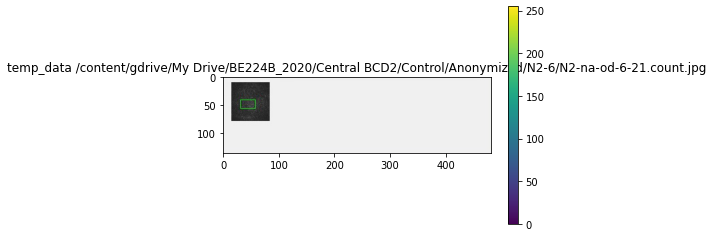

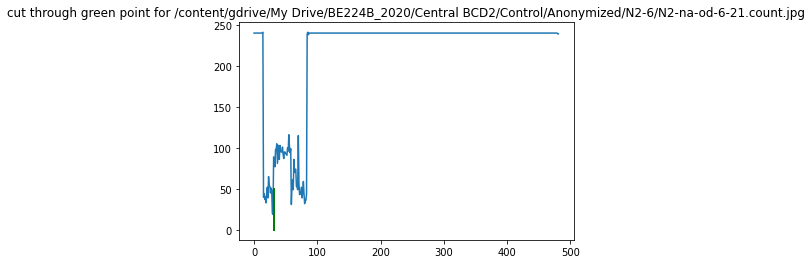

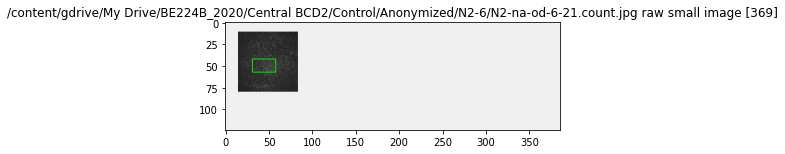

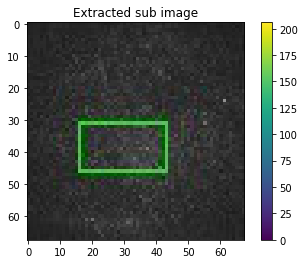

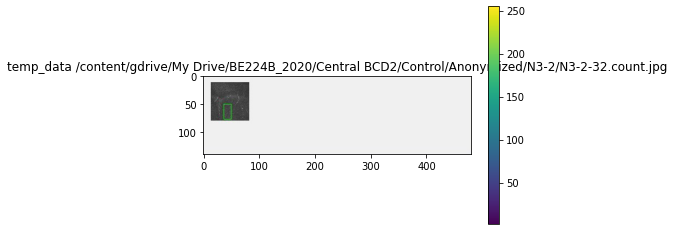

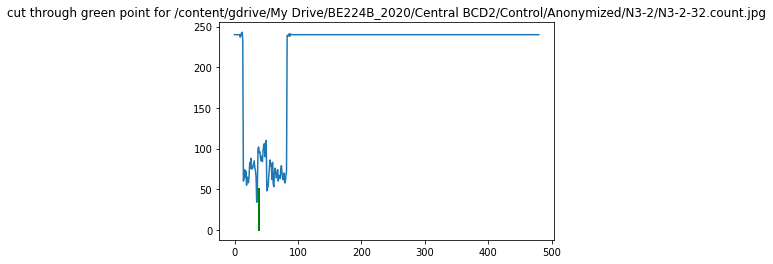

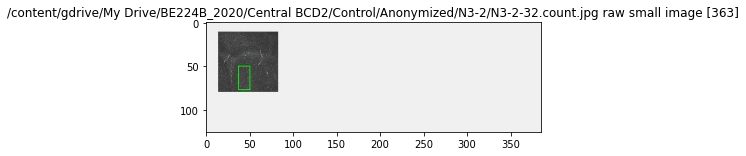

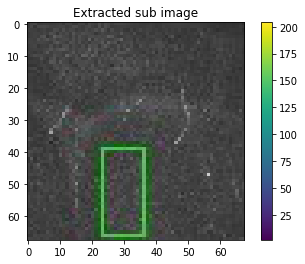

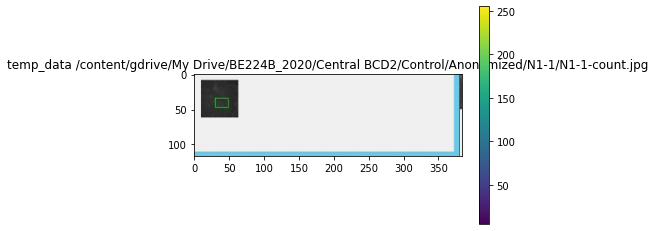

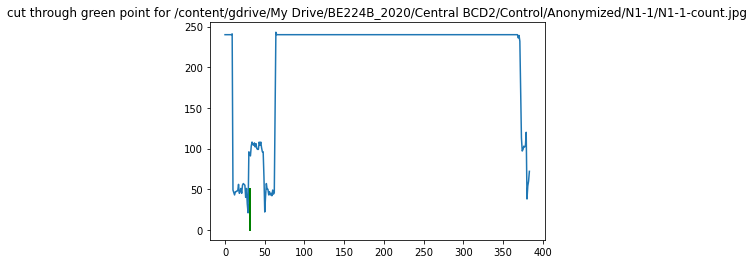

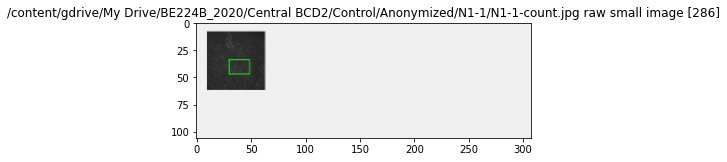

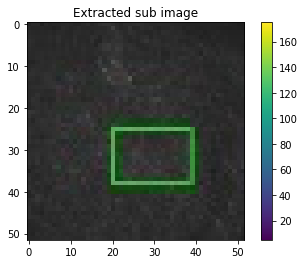

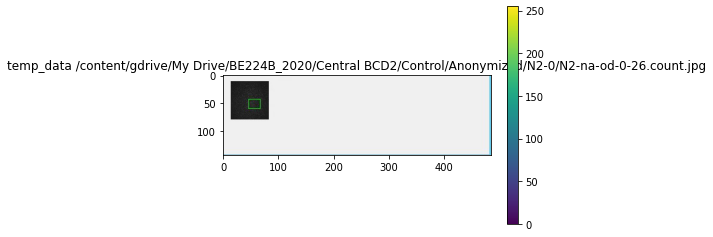

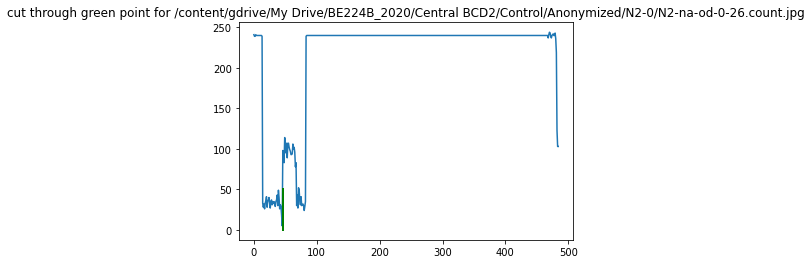

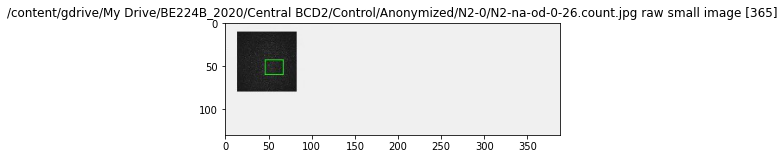

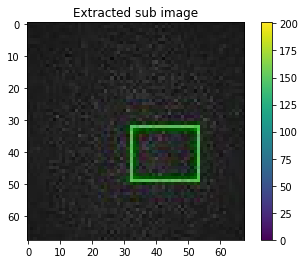

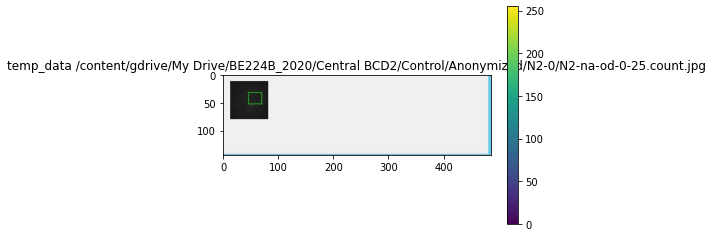

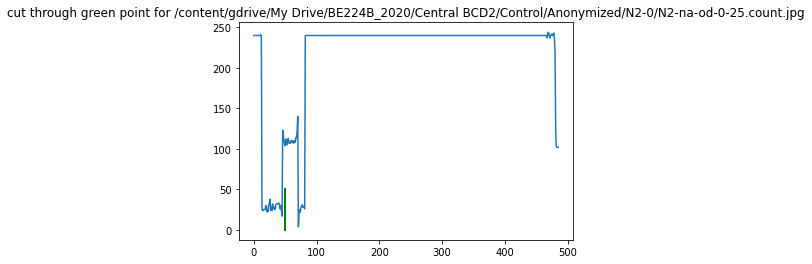

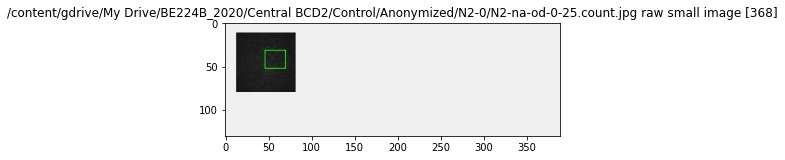

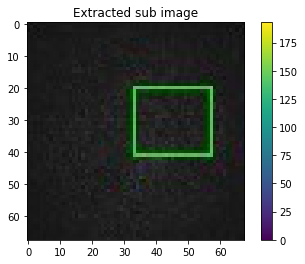

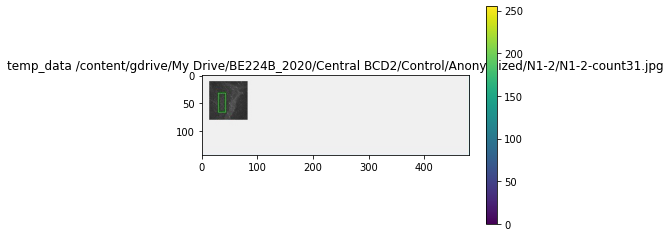

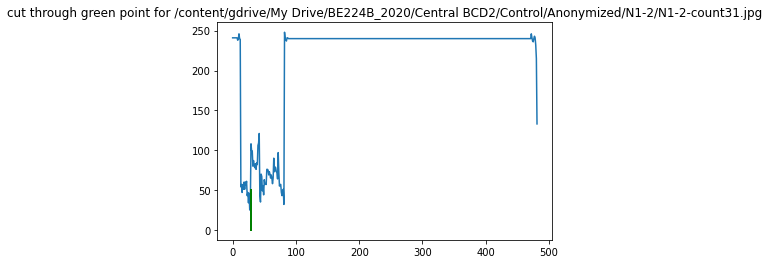

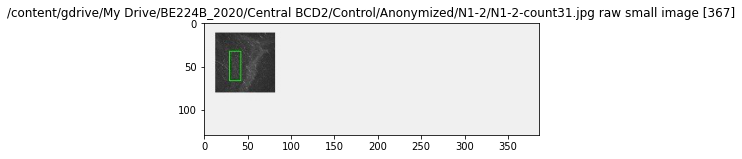

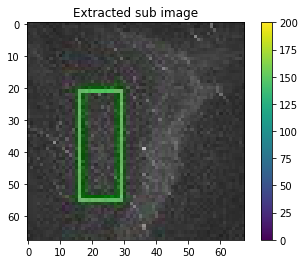

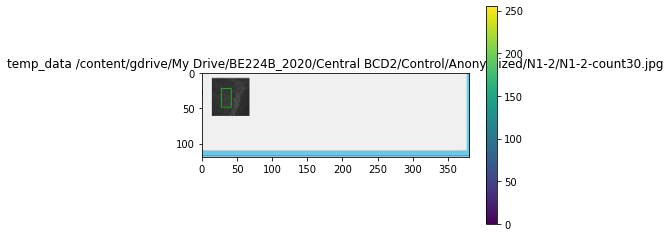

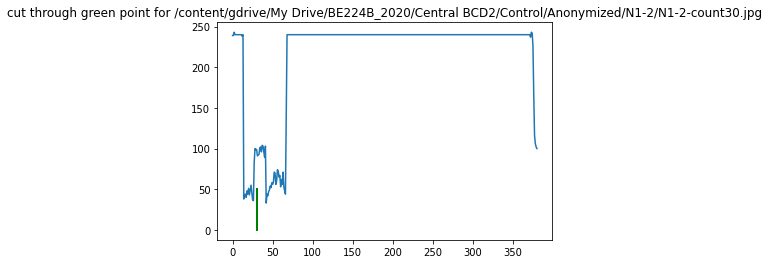

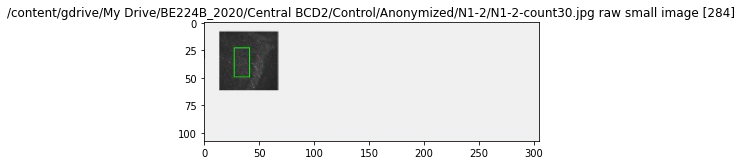

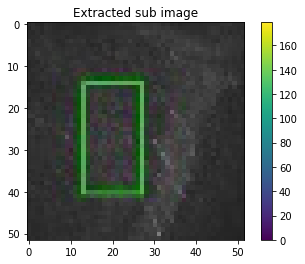

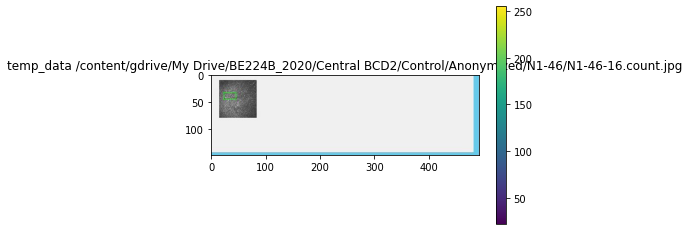

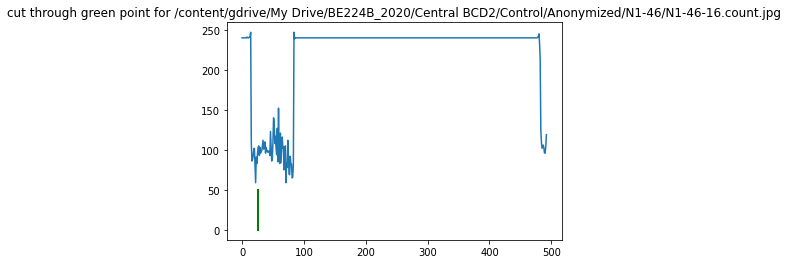

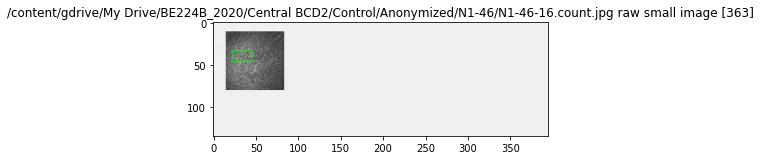

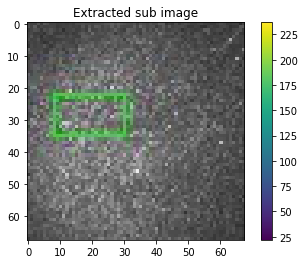

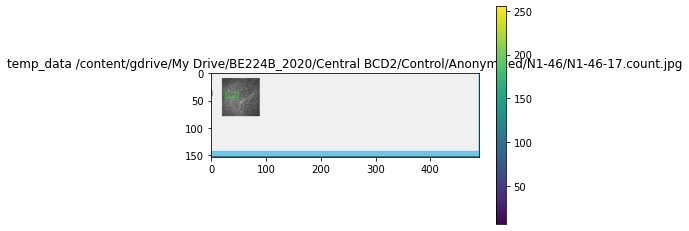

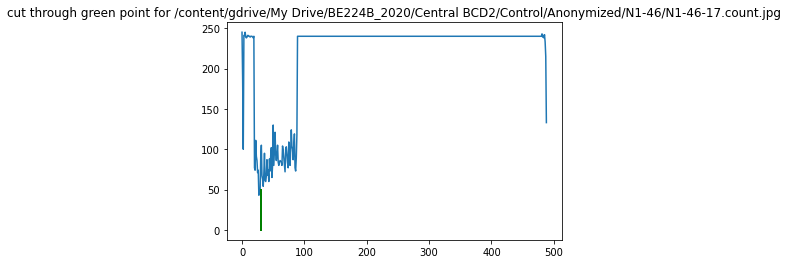

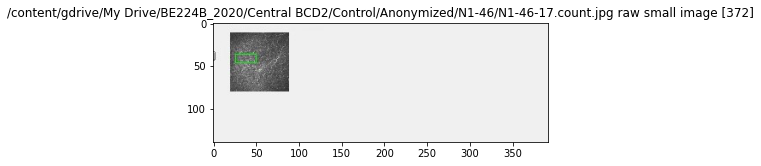

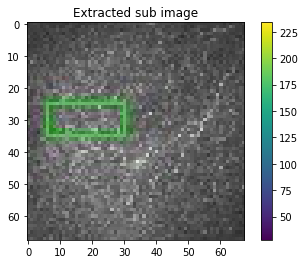

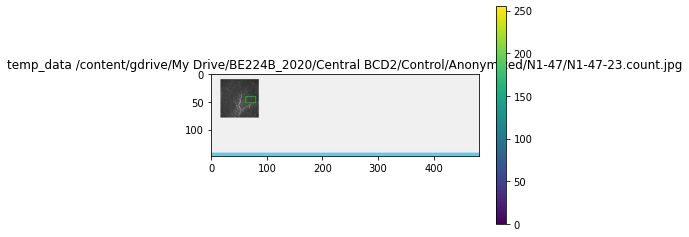

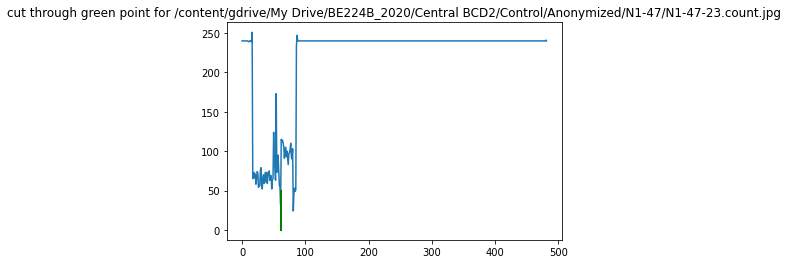

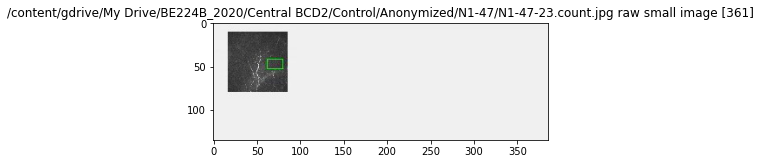

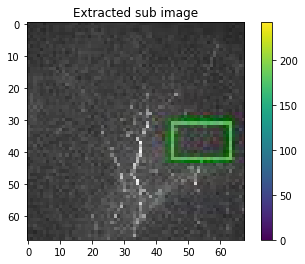

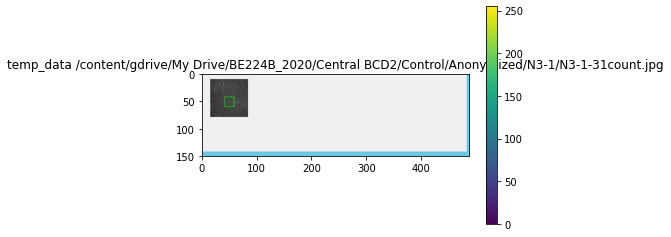

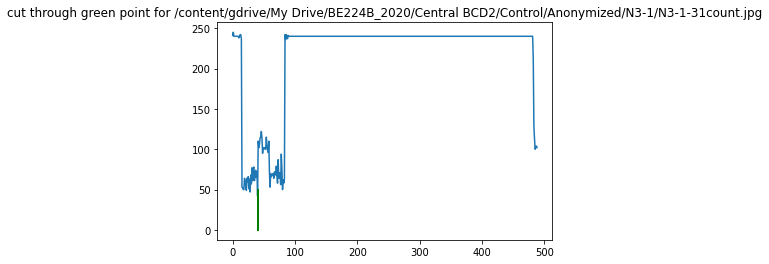

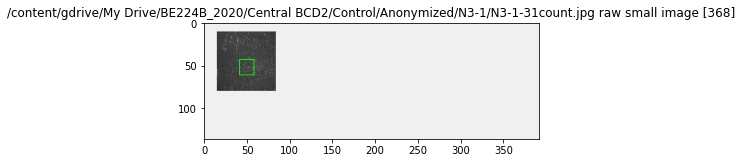

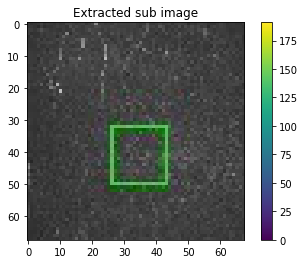

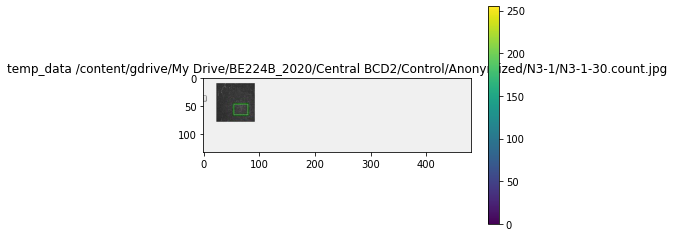

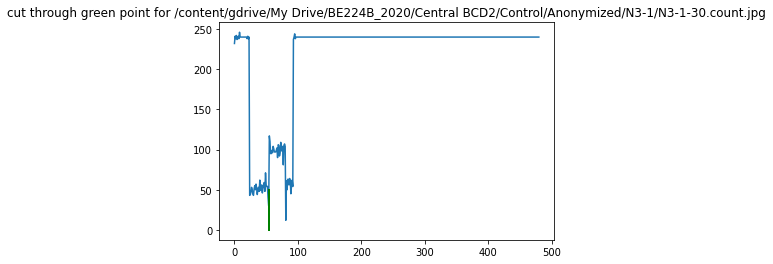

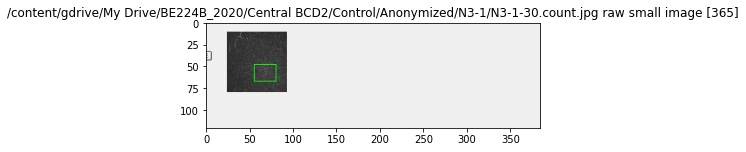

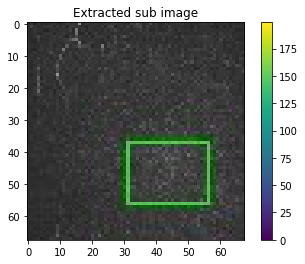

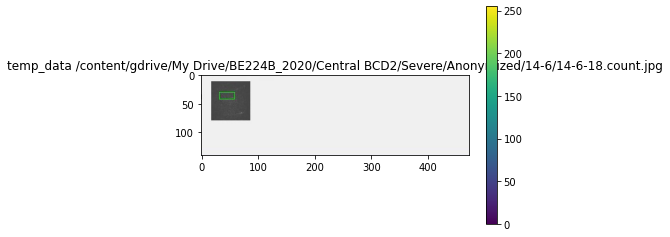

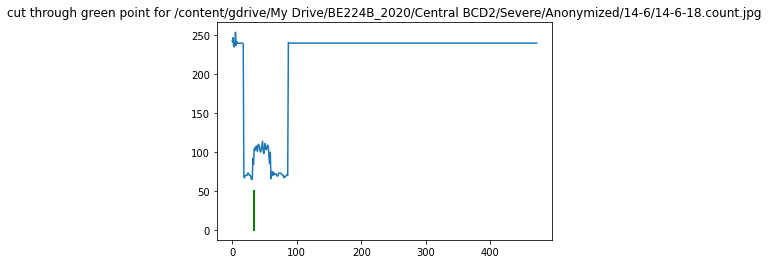

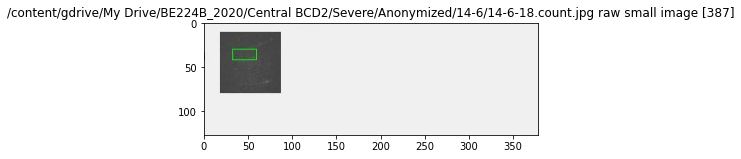

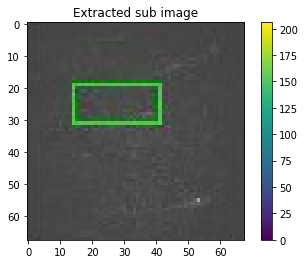

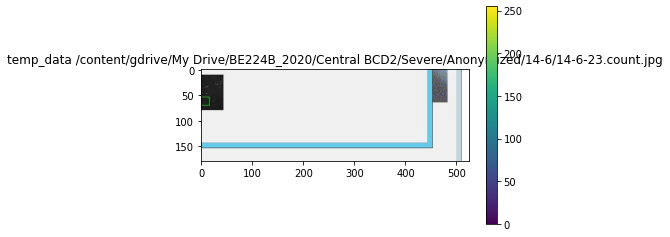

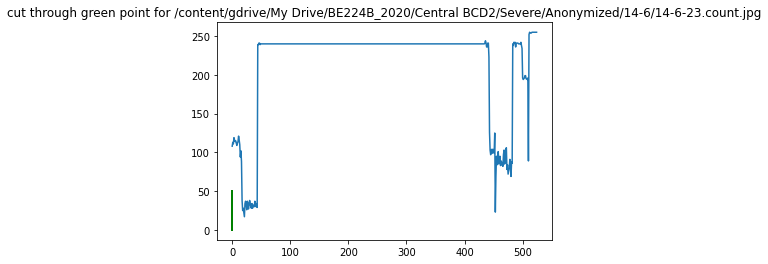

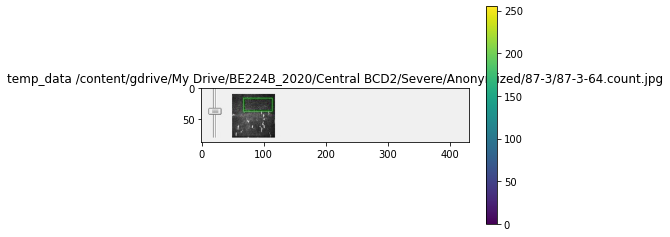

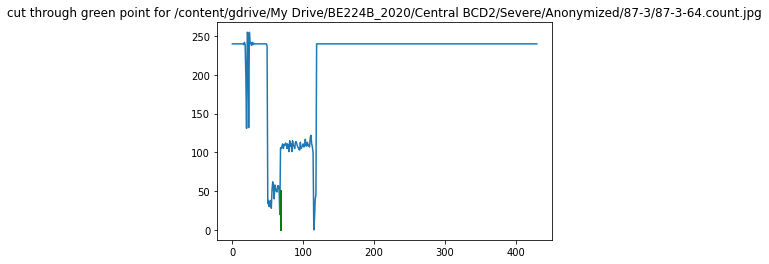

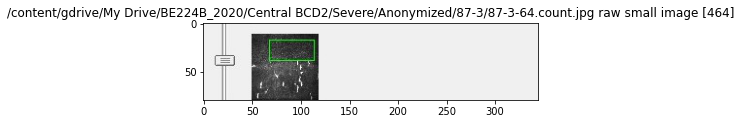

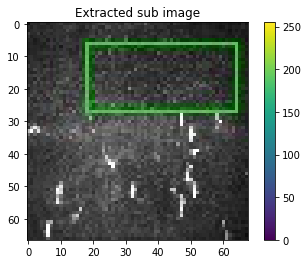

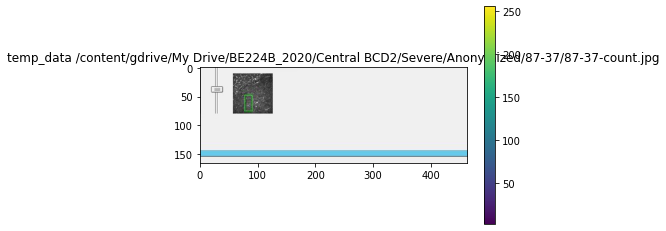

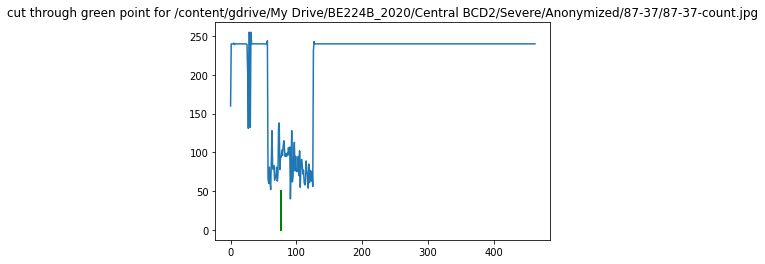

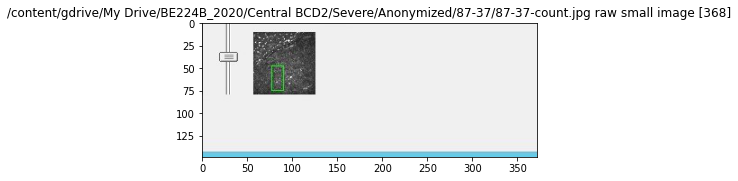

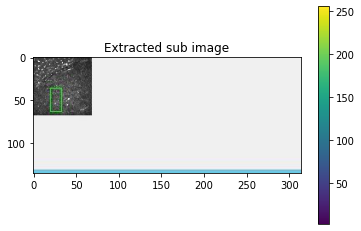

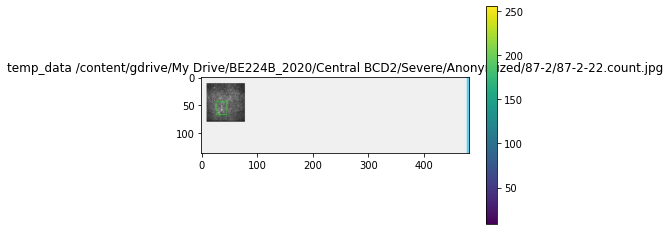

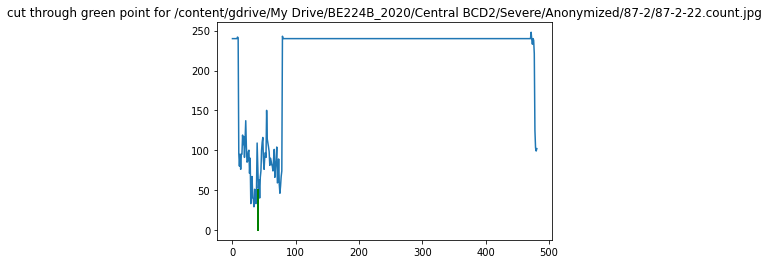

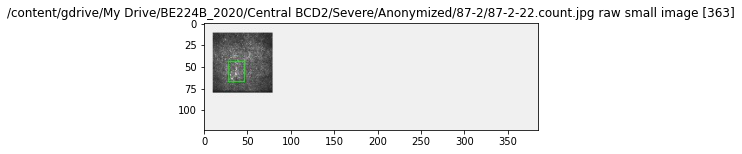

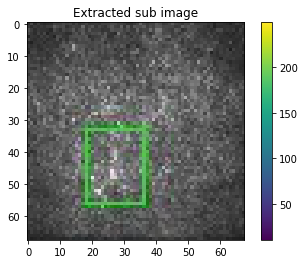

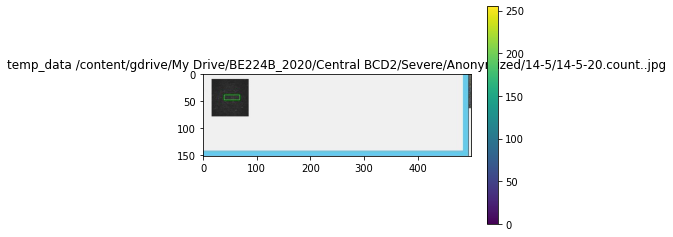

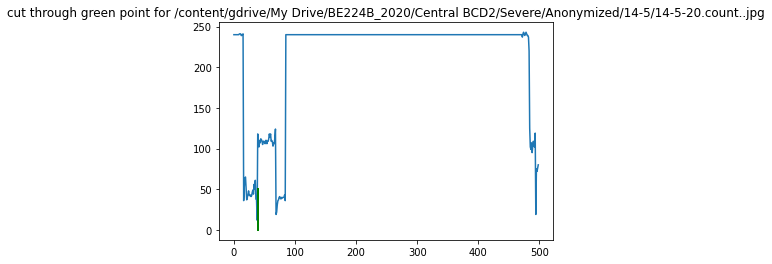

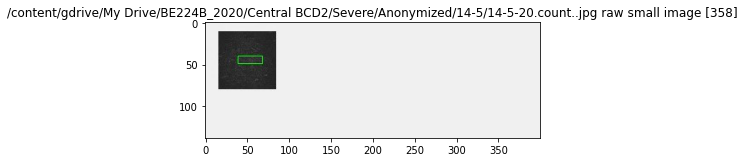

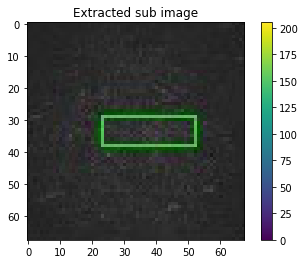

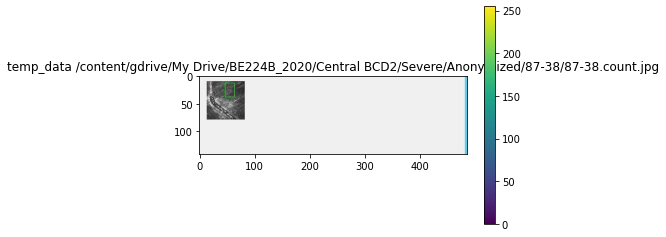

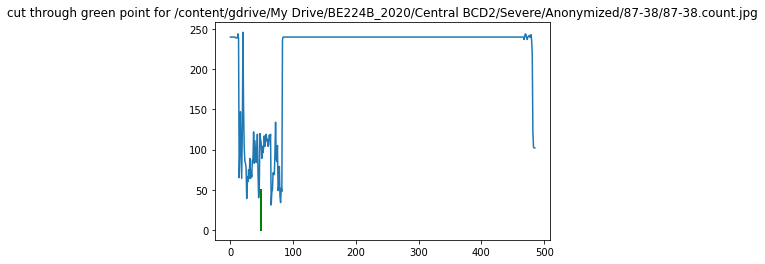

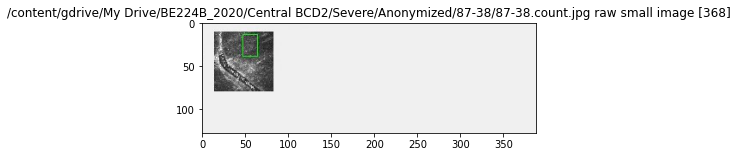

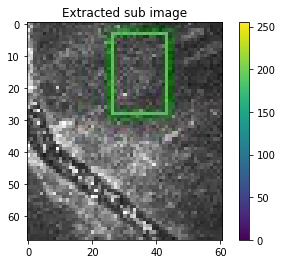

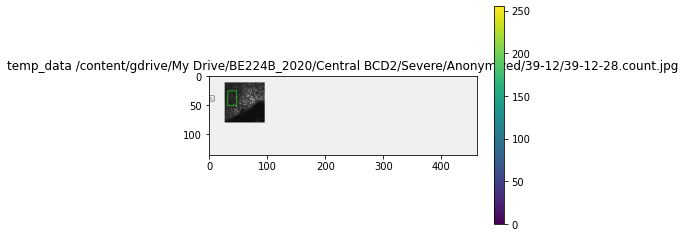

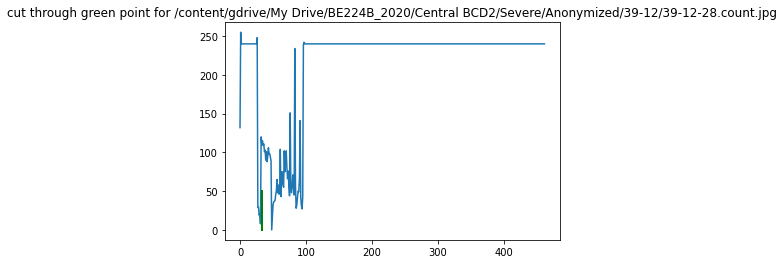

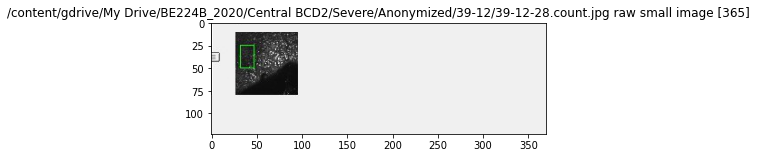

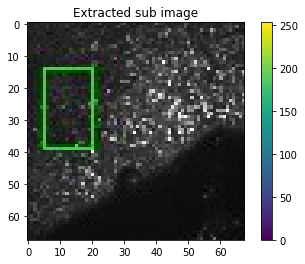

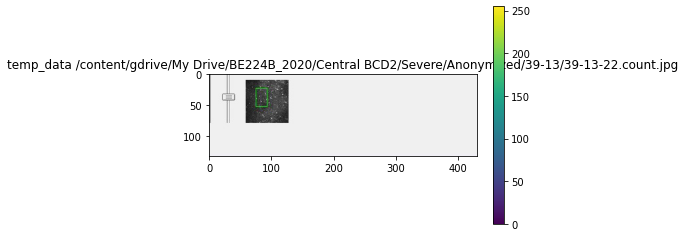

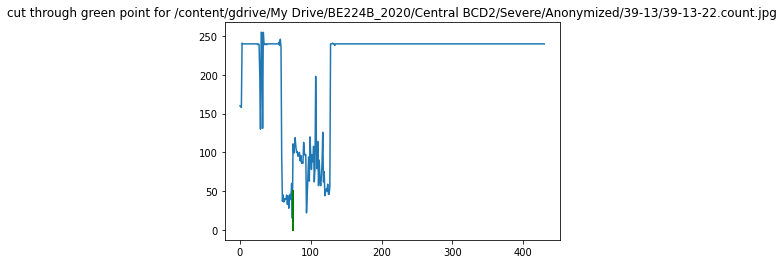

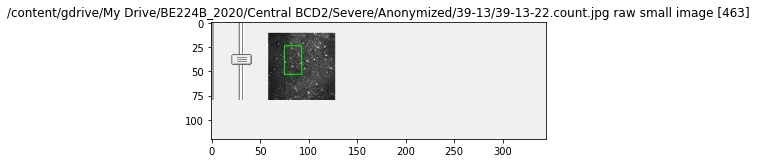

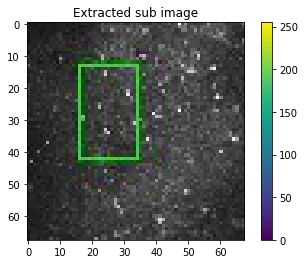

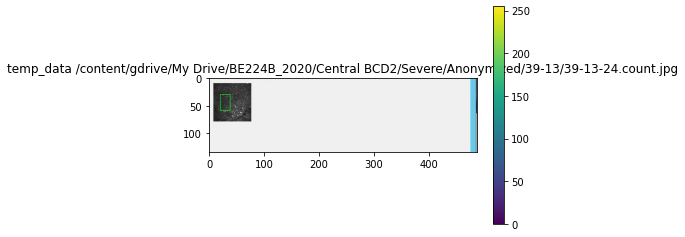

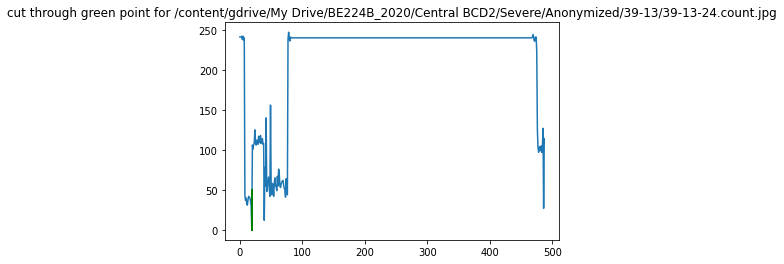

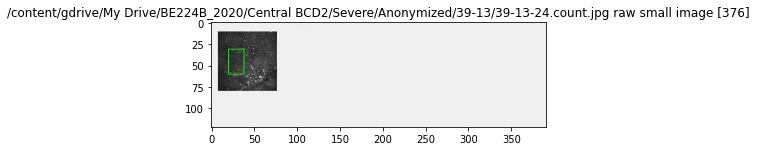

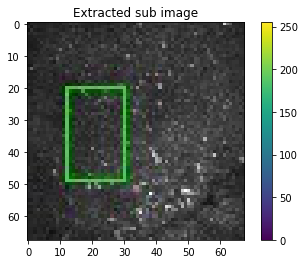

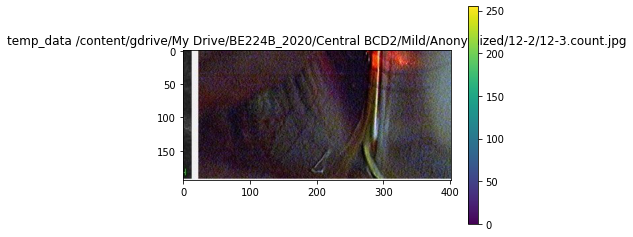

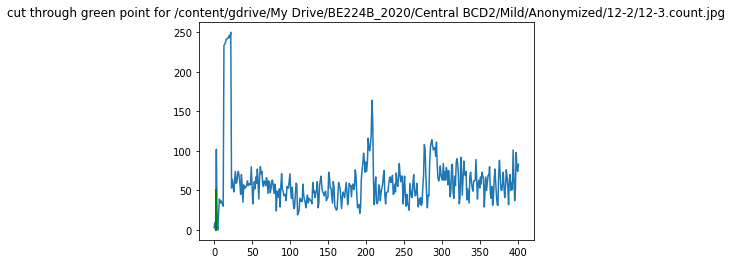

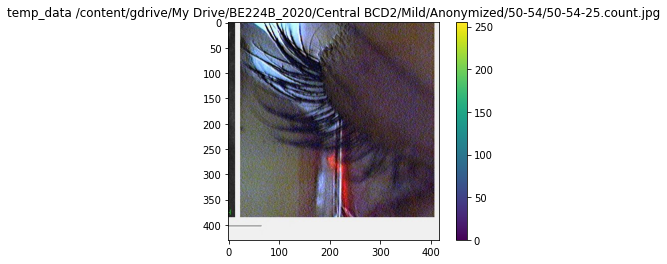

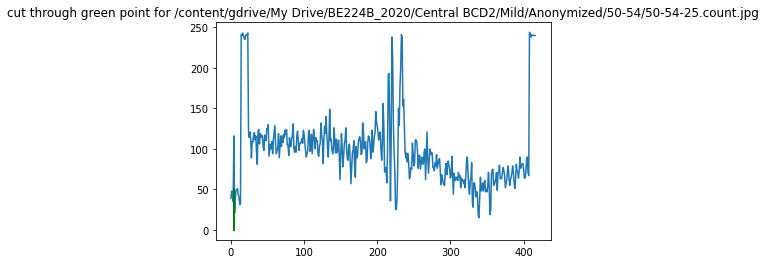

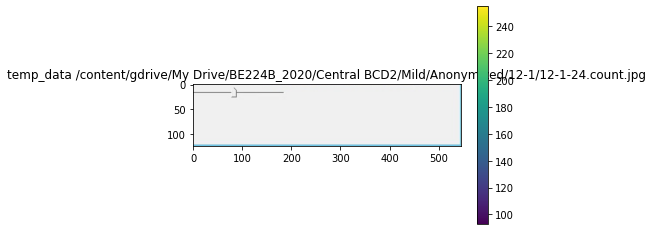

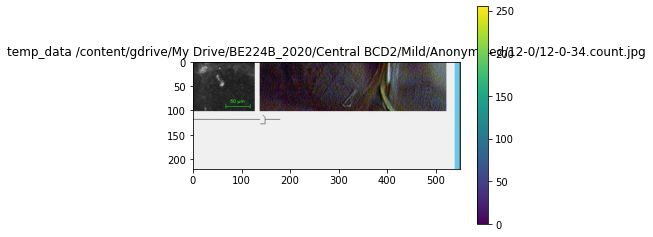

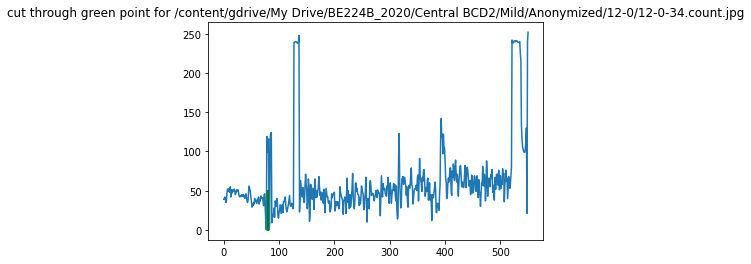

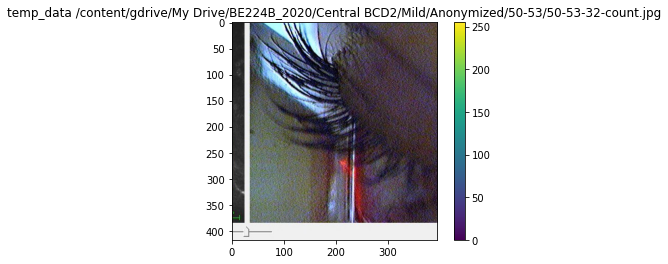

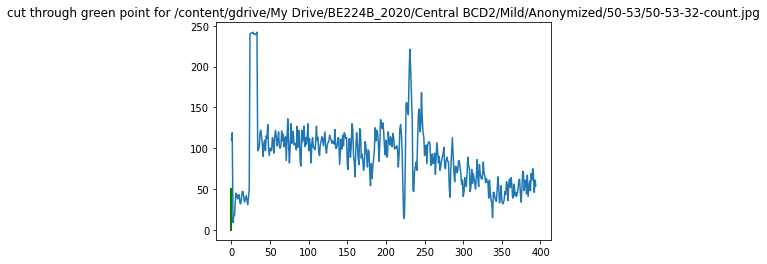

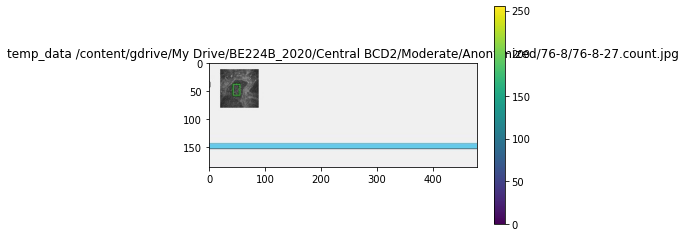

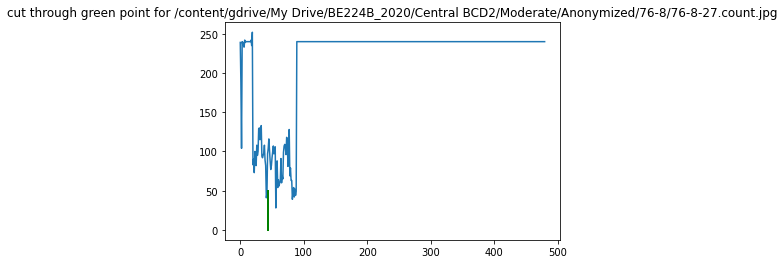

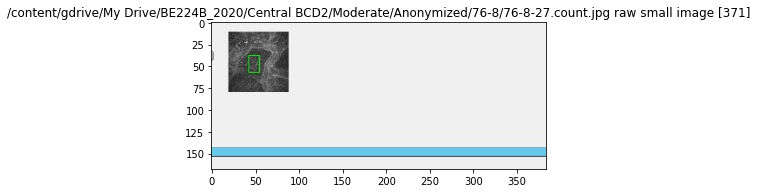

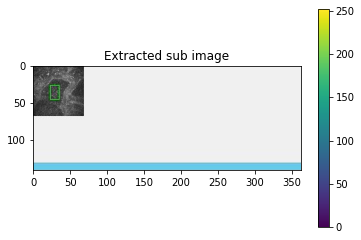

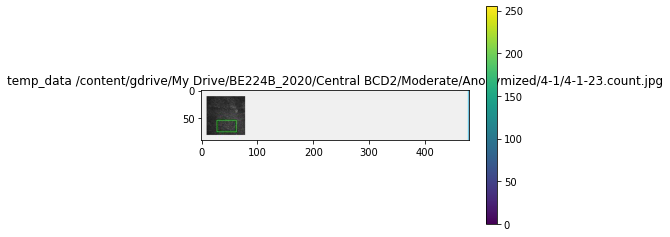

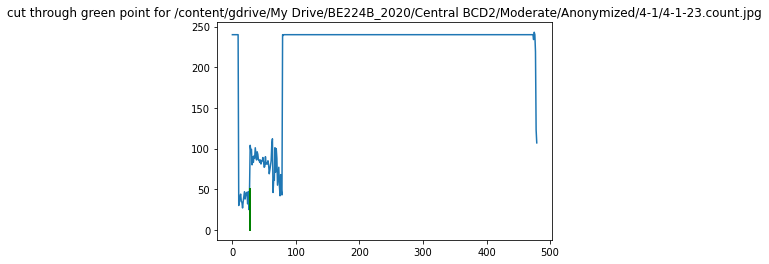

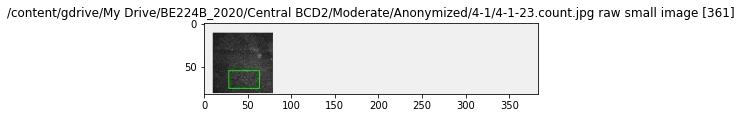

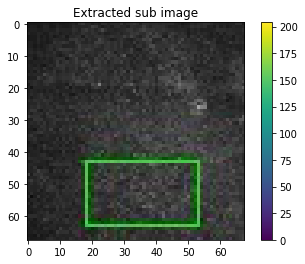

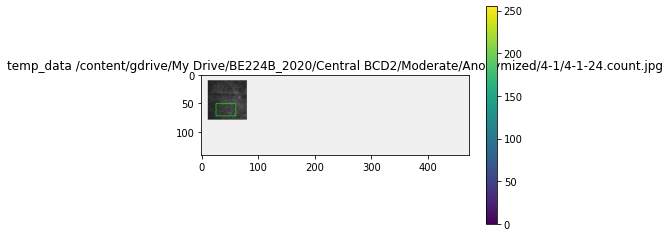

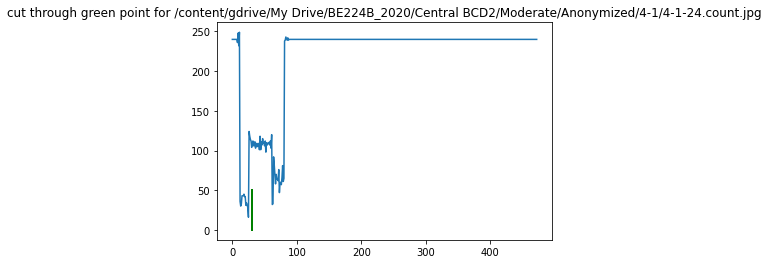

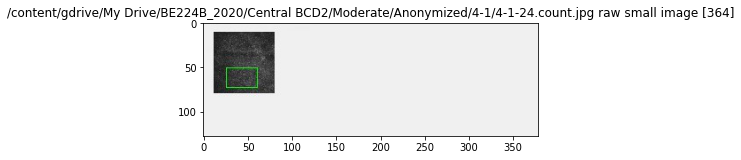

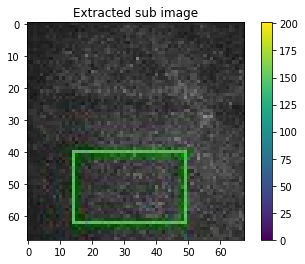

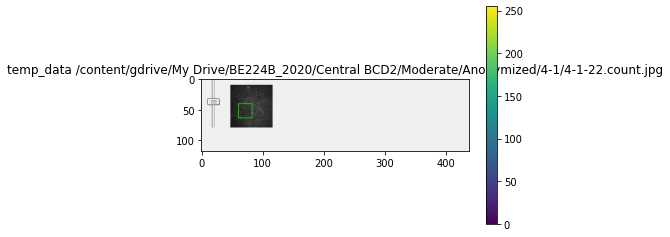

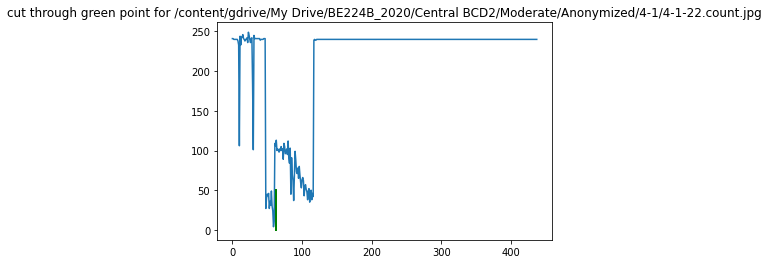

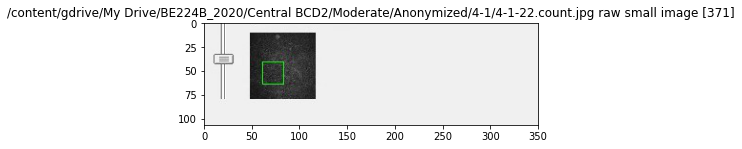

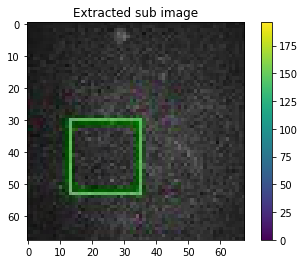

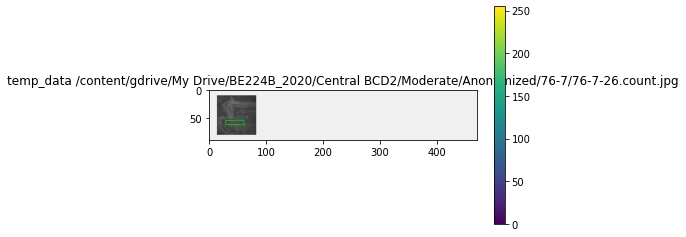

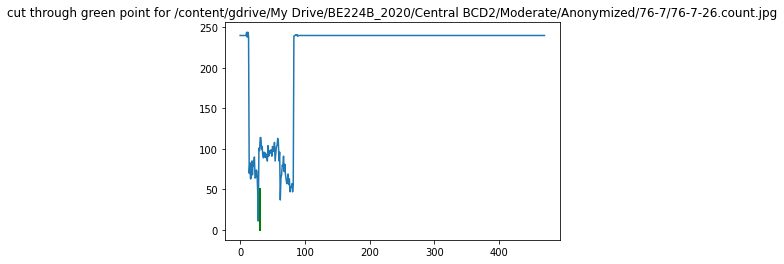

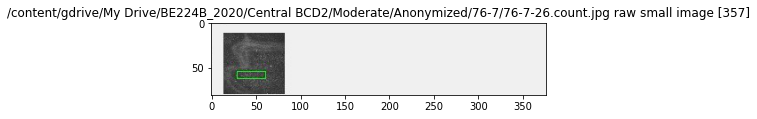

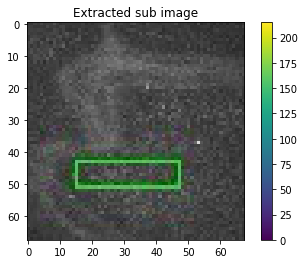

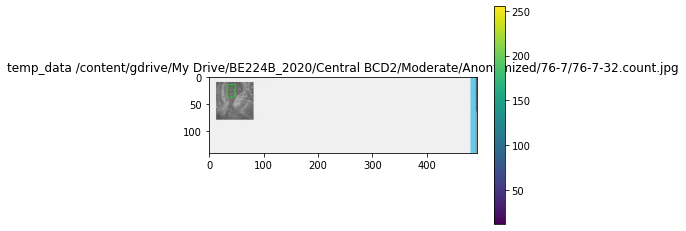

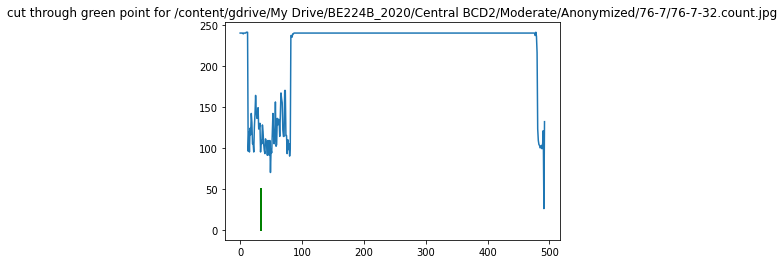

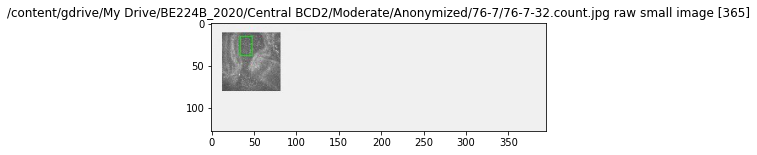

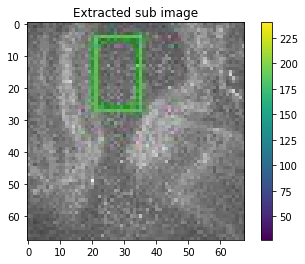

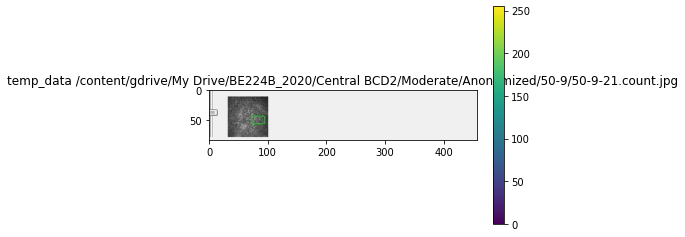

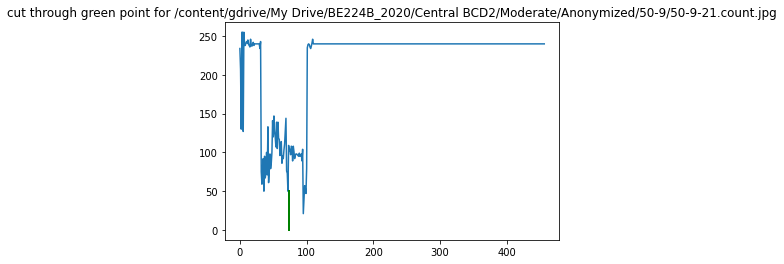

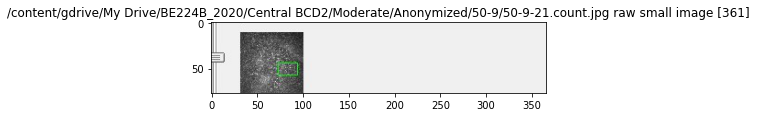

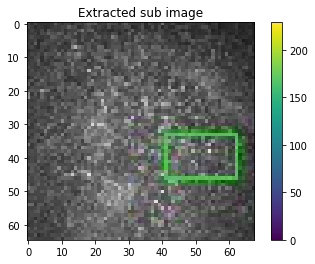

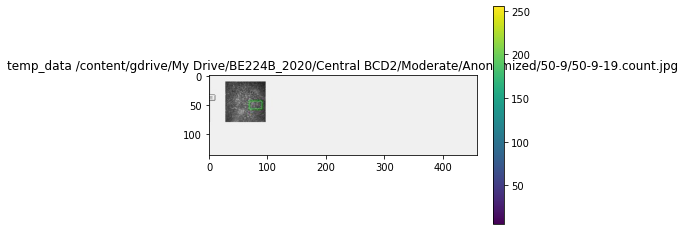

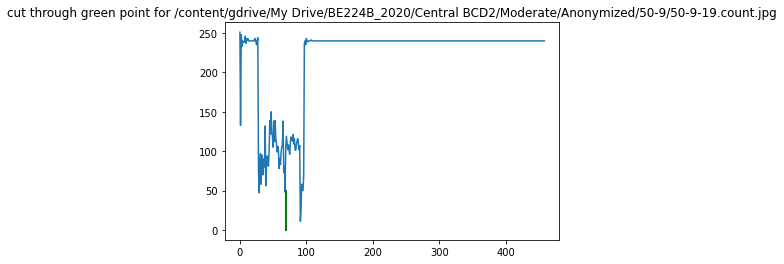

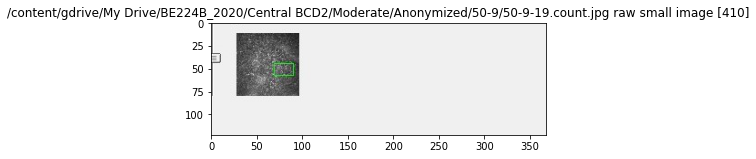

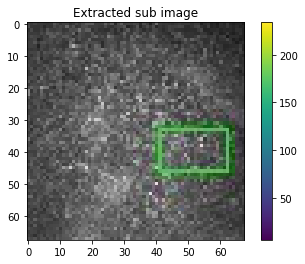

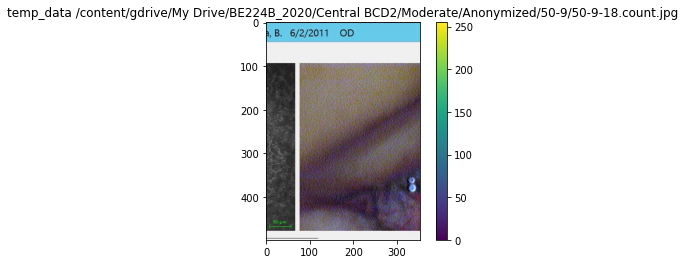

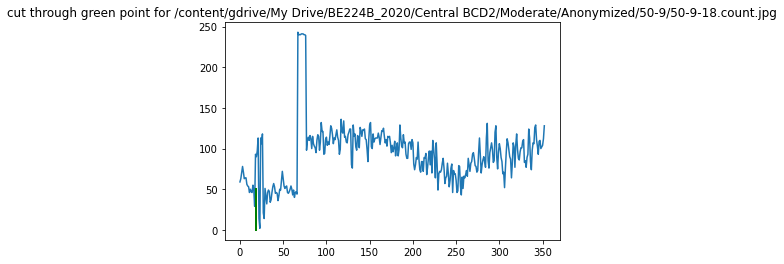

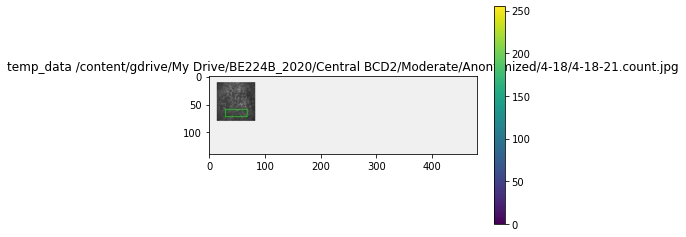

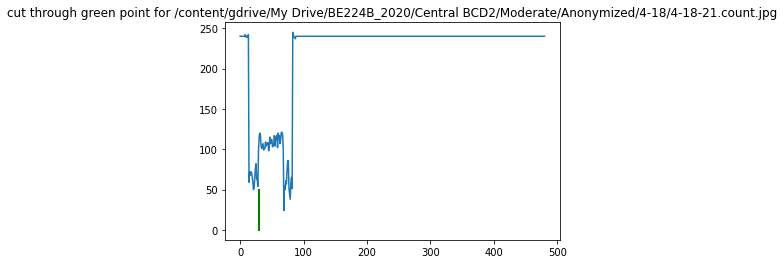

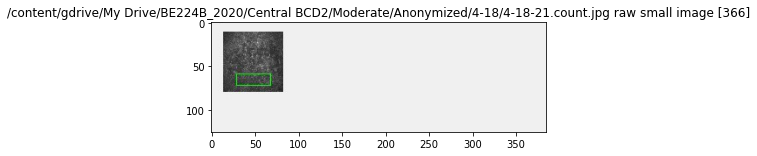

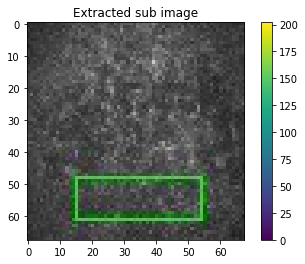

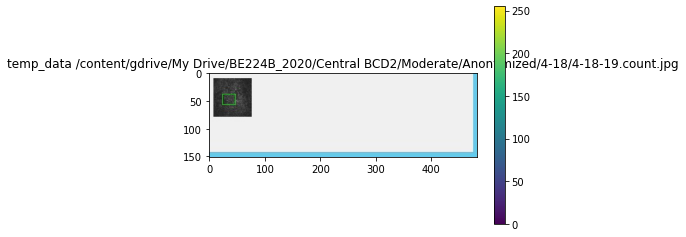

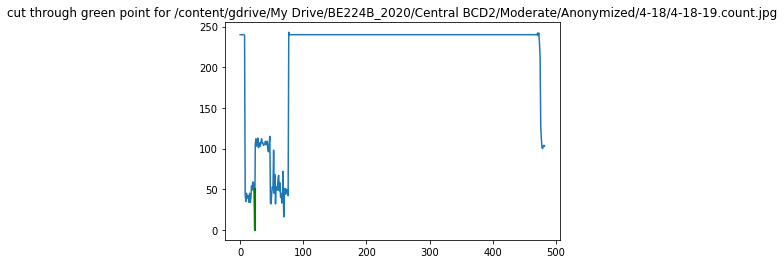

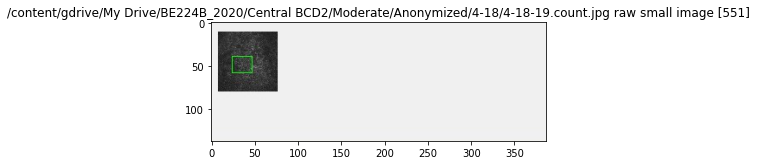

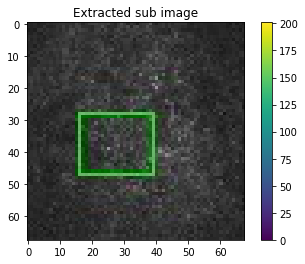

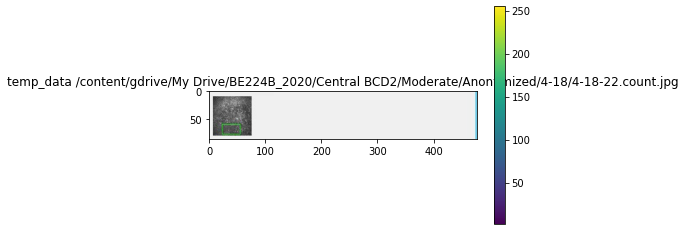

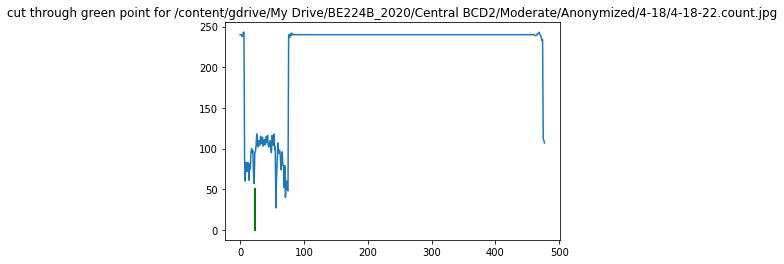

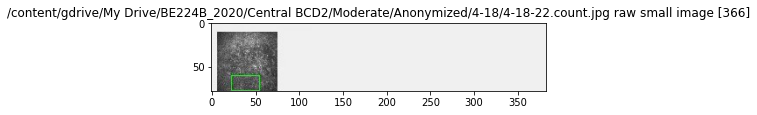

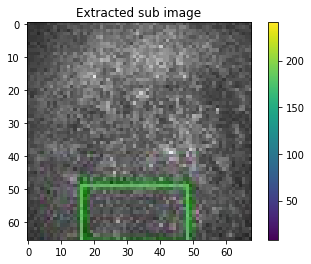

In [74]:
'''
Load the data by severity folders or aggregate folders
'''

if (image_type == 0):

    #BCD2 image set,just use the anon folder data
    im={}
    mini_im={} #subset images from counter image file

    full_patient_list ={}
    for sname in severity_list:
        folders = patient_folder[sname]
        full_patient_list[sname] ={}

        #
        # We are concerned with ANON folders for the annotation
        #
        for folder_name in folders:
            if 'ANON' in folder_name.upper():
                full_patient_list[sname][folder_name] = os.path.join(tp_dir,sname,folder_name)

    #
    # Get file listing
    #
    patient_files ={} #hold the anon images
    case_files = {} #hold files for each case folder
    for sname in full_patient_list.keys(): #severity folders
        patient_files[sname]= []
        case_files[sname] ={}

        #if 'ANON' in sname.upper():
            #get files only from anonymous folders
        for sub_dir in full_patient_list[sname]:
            if 'ANON' in sub_dir.upper():

                case_files[sname][sub_dir] ={} #just using Anonymous folder for now
                patient_dir = os.path.join(tp_dir,sname,sub_dir)
                case_dir = os.listdir(patient_dir)
                patient_files[sname].append(case_dir)


                for case_name in case_dir:
                    case_files[sname][sub_dir][case_name] = []
                    full_path = os.path.join(tp_dir,sname,sub_dir, case_name)
                    temp_list = os.listdir(full_path)
                    for filename in temp_list: #get all files within pt folder  
                        case_files[sname][sub_dir][case_name].append(filename)
            else: #series of images
                continue

    for sname in case_files.keys():
        im[sname] = {}
        mini_im[sname] = {}

        #im[sname]['ANON'] = {}
        for case_name in case_files[sname].keys():
            im[sname][case_name] = {}
            mini_im[sname][case_name] = {}

            print(case_files[sname].keys())
            for pt_dir in case_files[sname][case_name]:
                
                im[sname][case_name][pt_dir] = {}
                mini_im[sname][case_name][pt_dir] = {}


                print('patient directory is ', pt_dir)
                image_files = os.listdir(os.path.join(tp_dir,sname,case_name,pt_dir))
                print('\timage_files found= ',image_files)

                for filename in image_files:
                    #Read full image into dictionaries
                    if ('COUNT' not in filename.upper()):
                        full_file = os.path.join(tp_dir,sname,case_name,pt_dir,filename)
                        im[sname][case_name][pt_dir][filename] = imageio.imread(full_file)

                    else: #the annotated file would be here
                        print('!!!!! FOUND COUNT FILE')
                        full_file = os.path.join(tp_dir,sname,case_name,pt_dir,filename)
                        mini_im[sname][case_name][pt_dir][filename] = get_mini_image(full_file)



elif(image_type == 1):
    '''
    Load TIFF images into matrix
    '''
    patient_list = os.listdir(image_dir)

    im = {}
    for folder in patient_list:
        
        folder_check = os.path.isdir(os.path.join(image_dir,folder))
        if ( folder_check == False):
            print('skipping non directory entry ', folder)
            continue

        file_list = os.listdir(os.path.join(image_dir,folder))

        im[folder] ={}
        for filename in file_list:
            if ".JPG" in filename.upper():
                imdata = imageio.imread(os.path.join(image_dir,folder,filename))
                root_ext = os.path.splitext(filename) #will return two parts, name and ext
                keyname = root_ext[0] #dump the extension for the key 
                im[folder][keyname]=np.array(imdata)
            else:
                print('skipping ', filename)                

        #root_ext = os.path.splitext(fname) #will return two parts, name and ext
        #filename=root_ext[0]

else:
    #use aggregated folder, which has all images in one folder
    patient_folder = image_dir
    small_image_list =[]
    file_list = os.listdir(image_dir)

    im={}

    for filename in file_list:
        if "dots" not in filename:
            #print('found dots',root_ext[0])
            small_image_list.append(filename)

            imdata = imageio.imread(os.path.join(image_dir,filename))
            im[filename] = np.array(imdata)
        else:
            continue
        


#
# different datasets will have slightly different structure ordering
#
if (image_type == 1):
    for folder in im.keys():
        for counter,image_key in enumerate(im[folder].keys()):
            if (counter == 0):
                print(np.shape(im[folder][image_key]))
            plt.figure()
            plt.imshow(im[folder][image_key])
            plt.colorbar()
elif (image_type == 2):
    for counter,ii in enumerate(im.keys()):
        if (counter == 0):
            print(np.shape(im[ii]))
        plt.figure()
        plt.imshow(im[ii])
        plt.colorbar()
        #get_square(im, row, col,dlength):

    #im = imageio.imread('filename')
    #im = np.array(im)

In [0]:
case_files.keys()

In [0]:
if (image_type == 1):
    klist = list(im.keys())
    klist[0]
    mlist = list(im[klist[0]].keys())
    print(mlist[0])
    a = im[klist[0]][mlist[0]][:,:,0]
elif (image_type == 2):
    klist = im.keys()
    print(klist)
    a = im[klist[0]]


plt.figure()
#a=im['D1_R1_day_9_Image1.tif'][:,:,2]
#a=im['D1_R4_day_9_Image6.tif'][0][:,:,2]
print(np.shape(a))

f = np.fft.fft2(a)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.imshow(magnitude_spectrum,vmin=0, vmax = 256)
plt.colorbar()

In [0]:
'''
Get Sharpness estimates per channel for a square
'''
from cycler import cycler #change default color cycles for plot

mcolor = ['Reds','Greens','Blues']
# Set the default color cycle
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "g", "b"])

if (image_type == 1): #Density Research Lab Raw images
    test_data = im['D1 R1 day 9']['Image1']

    plt.figure()
    plt.imshow(test_data)
    plt.colorbar()
    plt.title('FULL ORIGINAL IMAGE')

    #plot full channel subset 
    a = test_data[75:125,75:125,:].astype(int)
    plt.figure()
    plt.imshow(a)
    plt.colorbar()
    plt.title('small subset w/ all channels')

    #test line plot
    plt.figure()
    plt.plot(a[17,:,])
    plt.title('slice through row 17 of subset')
    plt.legend(('Chan 0','Chan 1','Chan 2'))



    #custom_cycler = (cycler(color=['c', 'm', 'y', 'k']) +
    #             cycler(lw=[1, 2, 3, 4]))
    fig = plt.figure()
    ax0=plt.gca()
    ax0 = plt.plot(a[:,7])
    ax0 = plt.title('slice through column 7 of subset')
    ax0 = plt.legend(('Chan 0','Chan 1','Chan 2'))

    



    #plt.figure()
    #plt.plot(a[:,7])
    #plt.title('slice through column of subset')  
    #plt.legend(('Chan 0','Chan 1','Chan 2'))
    #plt.show()

elif(image_type == 2):
    print('Running Image Type 2')
    test_data =im['D1_R1_day_9_Image1.tif']


    for ii in range(0,3):  #alternate color channels

        b=test_data[:,:,ii]

        image_shape = np.shape(b)
        
        

        #get a sample box for testing
        a = get_square(b, 100, 100,25).astype(int) #75,75 to 125,125

        dx = np.diff(a)[1:,:] # remove the first row
        dy = np.diff(a, axis=0)[:,1:] # remove the first column
        dnorm = np.sqrt(dx**2 + dy**2)
        sharpness = np.average(dnorm)


        b=dnorm[0,0]
        type(b)
        float(b)
        isinstance(float(b),float)

        plt.figure()
        plt.imshow(a, cmap=mcolor[ii])
        plt.colorbar()
        stext = 'original ' + str(ii)
        plt.title(stext)


        b=dnorm.astype(float)
        plt.figure()
        plt.imshow(b,cmap=mcolor[ii])
        plt.colorbar()
        stext = mcolor[ii] + ' Sharpness=' + str(sharpness)
        plt.title(stext)






In [0]:
plt.figure()
plt.plot(dx[10,:])

plt.figure()
plt.plot(a[11,:])
plt.title('original slice ')
dd = np.diff(a[11,:])
plt.figure()
plt.plot(dd)

plt.figure()
plt.imshow(a)
plt.colorbar()
plt.title('original box')

plt.figure()
plt.imshow(dx,cmap='Reds')
plt.colorbar()

plt.figure()
plt.imshow(dy)
plt.colorbar()

In [0]:
mini_im['Control']['Anonymized']